In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


In [3]:
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, Activation, Lambda, Conv2DTranspose, add
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from skimage.color import rgb2gray
from glob import glob
from tqdm.notebook import tqdm
from itertools import chain
import pathlib
import random
from IPython.display import display

In [5]:
create_dir('files')
batch_size = 16
lr = 1e-4
num_epoch = 5
model_path = 'C:/Users/Harsha Vardhan/Downloads/skincancer/files/model.h5'
csv_path = 'C:/Users/Harsha Vardhan/Downloads/skincancer/GroundTruth.csv'


In [6]:
def load_data(dataset_path, split=0.2):
    images = sorted(glob(os.path.join(dataset_path, 'images', '*.jpg')))
    masks = sorted(glob(os.path.join(dataset_path, 'masks', '*.png')))
    test_size = int(len(images) * split)
    
    train_x, valid_x = train_test_split(images, test_size=test_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=test_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [7]:
dataset_path = 'C:/Users/Harsha Vardhan/Downloads/skincancer'
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)


In [8]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    
    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset


In [9]:
train_dataset = tf_dataset(train_x, train_y, batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch_size)


In [10]:
train_steps = len(train_x) // batch_size
valid_steps = len(valid_x) // batch_size

if len(train_x) % batch_size != 0:
    train_steps += 1
if len(valid_x) % batch_size != 0:
    valid_steps += 1

print("Number of training steps per epoch:", train_steps)


Number of training steps per epoch: 214


In [11]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model


In [12]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    # Model
    model = Model(inputs, outputs)
    return model


In [13]:
def build_double_unet(input_shape):
    inputs = Input(input_shape)

    # First U-Net
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output from first U-Net
    unet1_output = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    # Second U-Net
    s1_2, p1_2 = encoder_block(inputs, 64)
    s2_2, p2_2 = encoder_block(p1_2, 128)
    s3_2, p3_2 = encoder_block(p2_2, 256)
    s4_2, p4_2 = encoder_block(p3_2, 512)

    b1_2 = conv_block(p4_2, 1024)

    d1_2 = decoder_block(b1_2, s4_2, 512)
    d2_2 = decoder_block(d1_2, s3_2, 256)
    d3_2 = decoder_block(d2_2, s2_2, 128)
    d4_2 = decoder_block(d3_2, s1_2, 64)

    # Output from second U-Net
    unet2_output = Conv2D(1, 1, padding="same", activation="sigmoid")(d4_2)

    # Concatenate outputs of both U-Nets
    concatenated = concatenate([unet1_output, unet2_output], axis=-1)

    # Final processing after concatenation
    final_output = Conv2D(1, 1, padding="same", activation="sigmoid")(concatenated)

    # Model
    model = Model(inputs, final_output)
    return model


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [15]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision


In [16]:
model = build_unet((H, W, 3))

# Compile the model
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=metrics)

# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0

In [19]:
callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]


In [20]:
model.fit(
    train_dataset,
    epochs=num_epoch,
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/5
214/214 [==============================] - ETA: 0s - loss: 0.2596 - dice_coef: 0.7117 - iou: 0.5598 - recall: 0.7803 - precision: 0.8444 
Epoch 1: val_loss improved from inf to 0.79029, saving model to C:/Users/Harsha Vardhan/Downloads/skincancer/files\model.h5


C:\Users\Harsha Vardhan\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


214/214 [==============================] - 5846s 27s/step - loss: 0.2596 - dice_coef: 0.7117 - iou: 0.5598 - recall: 0.7803 - precision: 0.8444 - val_loss: 0.7903 - val_dice_coef: 0.2215 - val_iou: 0.1260 - val_recall: 0.0864 - val_precision: 0.9817 - lr: 1.0000e-04
Epoch 2/5
214/214 [==============================] - ETA: 0s - loss: 0.1729 - dice_coef: 0.8040 - iou: 0.6740 - recall: 0.8502 - precision: 0.9062 
Epoch 2: val_loss improved from 0.79029 to 0.21111, saving model to C:/Users/Harsha Vardhan/Downloads/skincancer/files\model.h5
214/214 [==============================] - 6029s 28s/step - loss: 0.1729 - dice_coef: 0.8040 - iou: 0.6740 - recall: 0.8502 - precision: 0.9062 - val_loss: 0.2111 - val_dice_coef: 0.7758 - val_iou: 0.6366 - val_recall: 0.7573 - val_precision: 0.9461 - lr: 1.0000e-04
Epoch 3/5
214/214 [==============================] - ETA: 0s - loss: 0.1541 - dice_coef: 0.8259 - iou: 0.7049 - recall: 0.8664 - precision: 0.9152 
Epoch 3: val_loss improved from 0.21111 to

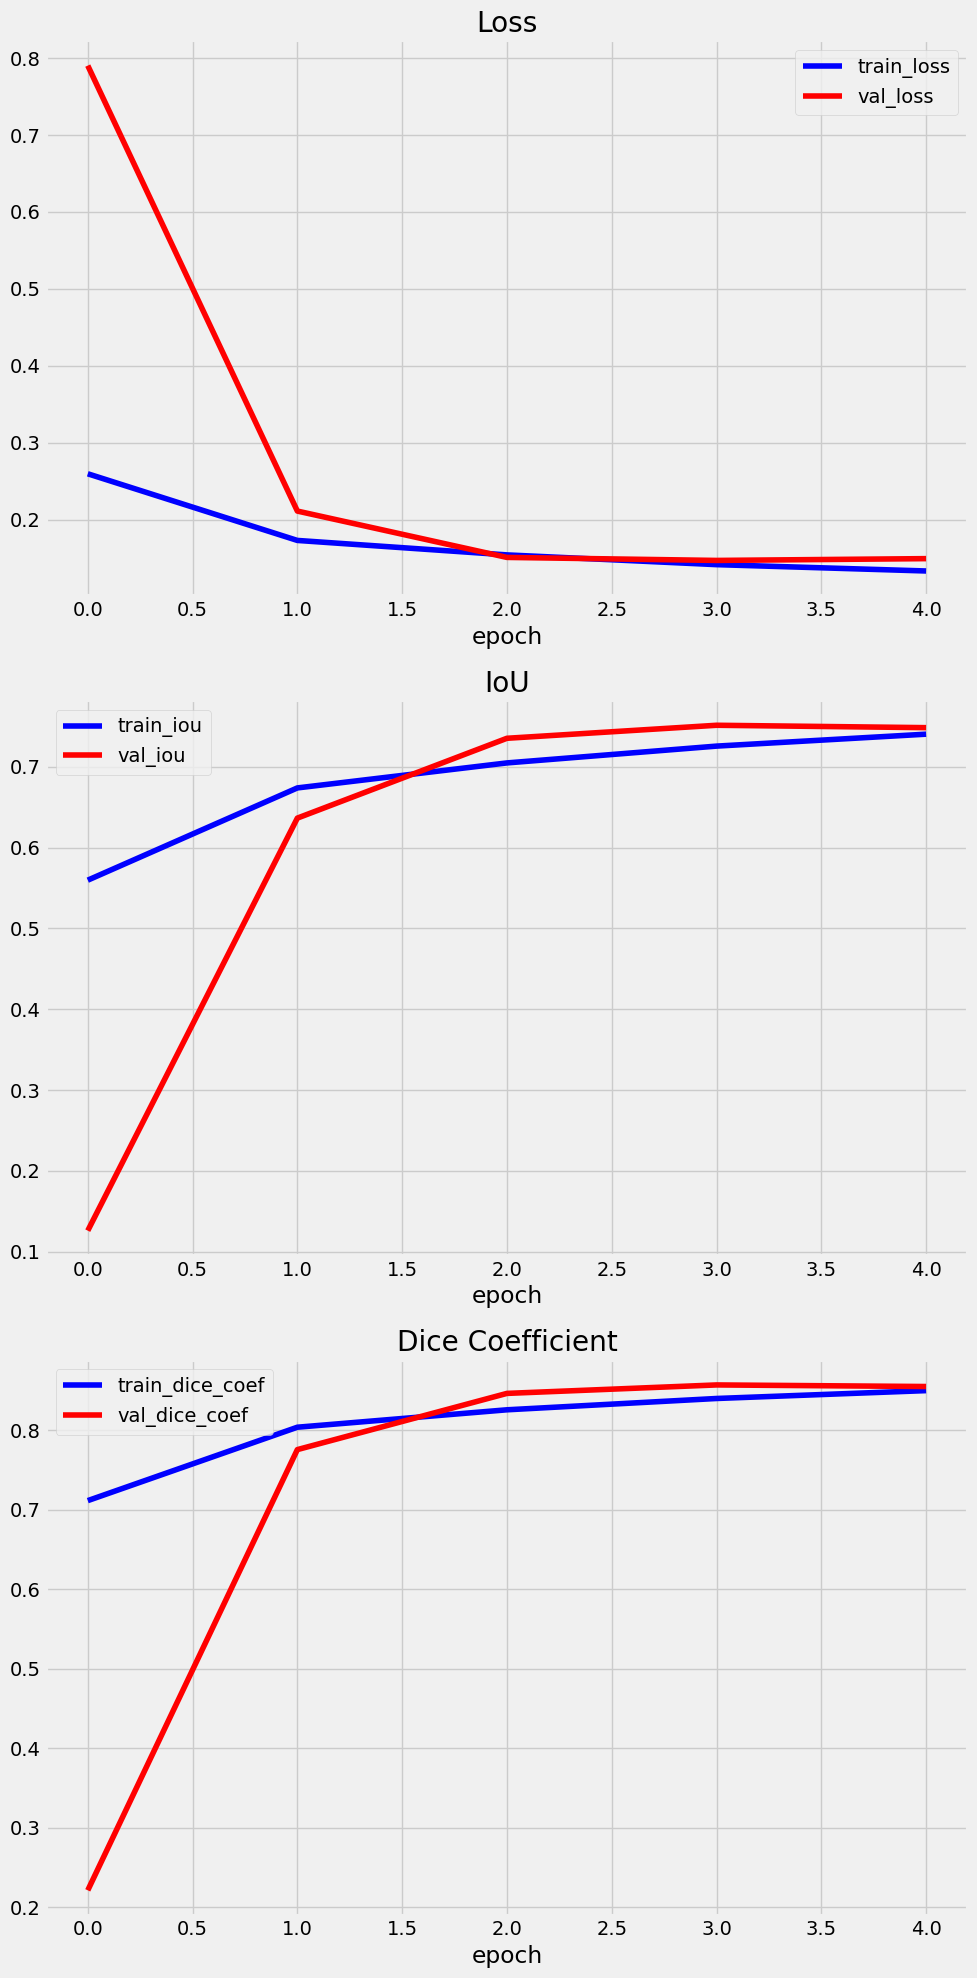

In [21]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 20))

# Plot training and validation loss
plt.subplot(3, 1, 1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.title('Loss')

# Plot training and validation IoU
plt.subplot(3, 1, 2)
plt.plot(model.history.history['iou'], 'b-', label='train_iou')
plt.plot(model.history.history['val_iou'], 'r-', label='val_iou')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.title('IoU')

# Plot training and validation Dice Coefficient
plt.subplot(3, 1, 3)
plt.plot(model.history.history['dice_coef'], 'b-', label='train_dice_coef')
plt.plot(model.history.history['val_dice_coef'], 'r-', label='val_dice_coef')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.title('Dice Coefficient')

plt.tight_layout()
plt.show()


In [25]:
import os
import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, precision_score

H = 256
W = 256

def read_image1(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)  ## (H, W, 3)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x / 255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x  ## (1, 256, 256, 3)

def read_mask1(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (H, W)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x / 255.0
    x = x.astype(np.int32)  ## (256, 256)
    return ori_x, x

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)  ## (256, 256, 1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1) ## (256, 256, 3)

    y_pred = np.expand_dims(y_pred, axis=-1)  ## (256, 256, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) ## (256, 256, 3)

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred * 255], axis=1)
    cv2.imwrite(save_image_path, cat_images)

def iou(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + 1e-15) / (union + 1e-15)

def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + 1e-15) / (np.sum(y_true) + np.sum(y_pred) + 1e-15)

def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def sensitivity(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred == 0))
    return true_positives / (true_positives + false_negatives + 1e-15)

def specificity(y_true, y_pred):
    true_negatives = np.sum((y_true == 0) & (y_pred == 0))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))
    return true_negatives / (true_negatives + false_positives + 1e-15)

def precision(y_true, y_pred):
    return precision_score(y_true, y_pred, average='binary')

if __name__ == "__main__":
    np.random.seed(42)
    tf.random.set_seed(42)

    create_dir("results")

    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
        model = tf.keras.models.load_model(r"C:\Users\Harsha Vardhan\Downloads\skincancer\files\model.h5")

    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        name = x.split("/")[-1]

        ori_x, x = read_image1(x)
        ori_y, y = read_mask1(y)

        y_pred = model.predict(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

        save_image_path = f"results/{name}"
        save_results(ori_x, ori_y, y_pred, save_image_path)

        y = y.flatten()
        y_pred = y_pred.flatten()

        iou_value = iou(y, y_pred)
        dsc_value = dice_coef(y, y_pred)
        acc_value = accuracy(y, y_pred)
        sen_value = sensitivity(y, y_pred)
        spc_value = specificity(y, y_pred)
        pre_value = precision(y, y_pred)

        SCORE.append([name, iou_value, dsc_value, acc_value, sen_value, spc_value, pre_value])

    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"IoU: {score[0]:0.5f}")
    print(f"DSC: {score[1]:0.5f}")
    print(f"Accuracy: {score[2]:0.5f}")
    print(f"Sensitivity: {score[3]:0.5f}")
    print(f"Specificity: {score[4]:0.5f}")
    print(f"Precision: {score[5]:0.5f}")

    df = pd.DataFrame(SCORE, columns=["Image Name", "IoU", "DSC", "Accuracy", "Sensitivity", "Specificity", "Precision"])
    df.to_csv(r"C:\Users\Harsha Vardhan\Downloads\skincancer\GroundTruth.csv")


  0%|                                                                                         | 0/1139 [00:00<?, ?it/s]

1/1 [==============================] - 1s 997ms/step


  0%|                                                                                 | 1/1139 [00:01<20:41,  1.09s/it]

1/1 [==============================] - 1s 586ms/step


  0%|▏                                                                                | 2/1139 [00:01<15:52,  1.19it/s]

1/1 [==============================] - 1s 596ms/step


  0%|▏                                                                                | 3/1139 [00:02<14:15,  1.33it/s]

1/1 [==============================] - 1s 591ms/step


  0%|▎                                                                                | 4/1139 [00:03<13:33,  1.40it/s]

1/1 [==============================] - 1s 583ms/step


  0%|▎                                                                                | 5/1139 [00:03<13:10,  1.43it/s]

1/1 [==============================] - 1s 589ms/step


  1%|▍                                                                                | 6/1139 [00:04<12:57,  1.46it/s]

1/1 [==============================] - 1s 590ms/step


  1%|▍                                                                                | 7/1139 [00:05<12:47,  1.48it/s]

1/1 [==============================] - 1s 569ms/step


  1%|▌                                                                                | 8/1139 [00:05<12:29,  1.51it/s]

1/1 [==============================] - 1s 581ms/step


  1%|▋                                                                                | 9/1139 [00:06<12:29,  1.51it/s]

1/1 [==============================] - 1s 592ms/step


  1%|▋                                                                               | 10/1139 [00:07<12:29,  1.51it/s]

1/1 [==============================] - 1s 572ms/step


  1%|▊                                                                               | 11/1139 [00:07<12:22,  1.52it/s]

1/1 [==============================] - 1s 601ms/step


  1%|▊                                                                               | 12/1139 [00:08<12:28,  1.51it/s]

1/1 [==============================] - 1s 569ms/step


  1%|▉                                                                               | 13/1139 [00:08<12:18,  1.52it/s]

1/1 [==============================] - 1s 566ms/step


  1%|▉                                                                               | 14/1139 [00:09<12:10,  1.54it/s]

1/1 [==============================] - 1s 578ms/step


  1%|█                                                                               | 15/1139 [00:10<12:10,  1.54it/s]

1/1 [==============================] - 1s 573ms/step


  1%|█                                                                               | 16/1139 [00:10<12:01,  1.56it/s]

1/1 [==============================] - 1s 581ms/step


  1%|█▏                                                                              | 17/1139 [00:11<12:05,  1.55it/s]

1/1 [==============================] - 1s 606ms/step


  2%|█▎                                                                              | 18/1139 [00:12<12:16,  1.52it/s]

1/1 [==============================] - 1s 587ms/step


  2%|█▎                                                                              | 19/1139 [00:12<12:14,  1.52it/s]

1/1 [==============================] - 1s 573ms/step


  2%|█▍                                                                              | 20/1139 [00:13<12:06,  1.54it/s]

1/1 [==============================] - 1s 573ms/step


  2%|█▍                                                                              | 21/1139 [00:14<12:07,  1.54it/s]

1/1 [==============================] - 1s 572ms/step


  2%|█▌                                                                              | 22/1139 [00:14<12:06,  1.54it/s]

1/1 [==============================] - 1s 591ms/step


  2%|█▌                                                                              | 23/1139 [00:15<12:09,  1.53it/s]

1/1 [==============================] - 1s 568ms/step


  2%|█▋                                                                              | 24/1139 [00:16<12:04,  1.54it/s]

1/1 [==============================] - 1s 591ms/step


  2%|█▊                                                                              | 25/1139 [00:16<12:07,  1.53it/s]

1/1 [==============================] - 1s 596ms/step


  2%|█▊                                                                              | 26/1139 [00:17<12:09,  1.53it/s]

1/1 [==============================] - 1s 596ms/step


  2%|█▉                                                                              | 27/1139 [00:18<12:06,  1.53it/s]

1/1 [==============================] - 1s 574ms/step


  2%|█▉                                                                              | 28/1139 [00:18<12:04,  1.53it/s]

1/1 [==============================] - 1s 593ms/step


  3%|██                                                                              | 29/1139 [00:19<12:11,  1.52it/s]

1/1 [==============================] - 1s 590ms/step


  3%|██                                                                              | 30/1139 [00:20<12:13,  1.51it/s]

1/1 [==============================] - 1s 583ms/step


  3%|██▏                                                                             | 31/1139 [00:20<12:15,  1.51it/s]

1/1 [==============================] - 1s 588ms/step


  3%|██▏                                                                             | 32/1139 [00:21<12:10,  1.52it/s]

1/1 [==============================] - 1s 612ms/step


  3%|██▎                                                                             | 33/1139 [00:22<12:17,  1.50it/s]

1/1 [==============================] - 1s 593ms/step


  3%|██▍                                                                             | 34/1139 [00:22<12:13,  1.51it/s]

1/1 [==============================] - 1s 592ms/step


  3%|██▍                                                                             | 35/1139 [00:23<12:11,  1.51it/s]

1/1 [==============================] - 1s 564ms/step


  3%|██▌                                                                             | 36/1139 [00:24<12:03,  1.52it/s]

1/1 [==============================] - 1s 561ms/step


  3%|██▌                                                                             | 37/1139 [00:24<11:55,  1.54it/s]

1/1 [==============================] - 1s 608ms/step


  3%|██▋                                                                             | 38/1139 [00:25<12:06,  1.52it/s]

1/1 [==============================] - 1s 598ms/step


  3%|██▋                                                                             | 39/1139 [00:26<12:10,  1.51it/s]

1/1 [==============================] - 1s 570ms/step


  4%|██▊                                                                             | 40/1139 [00:26<12:02,  1.52it/s]

1/1 [==============================] - 1s 572ms/step


  4%|██▉                                                                             | 41/1139 [00:27<11:46,  1.55it/s]

1/1 [==============================] - 1s 560ms/step


  4%|██▉                                                                             | 42/1139 [00:27<11:36,  1.57it/s]

1/1 [==============================] - 1s 594ms/step


  4%|███                                                                             | 43/1139 [00:28<11:47,  1.55it/s]

1/1 [==============================] - 1s 588ms/step


  4%|███                                                                             | 44/1139 [00:29<11:47,  1.55it/s]

1/1 [==============================] - 1s 560ms/step


  4%|███▏                                                                            | 45/1139 [00:29<11:41,  1.56it/s]

1/1 [==============================] - 1s 569ms/step


  4%|███▏                                                                            | 46/1139 [00:30<11:37,  1.57it/s]

1/1 [==============================] - 1s 611ms/step


  4%|███▎                                                                            | 47/1139 [00:31<11:49,  1.54it/s]

1/1 [==============================] - 1s 594ms/step


  4%|███▎                                                                            | 48/1139 [00:31<11:57,  1.52it/s]

1/1 [==============================] - 1s 603ms/step


  4%|███▍                                                                            | 49/1139 [00:32<11:59,  1.52it/s]

1/1 [==============================] - 1s 567ms/step


  4%|███▌                                                                            | 50/1139 [00:33<11:51,  1.53it/s]

1/1 [==============================] - 1s 569ms/step


  4%|███▌                                                                            | 51/1139 [00:33<11:42,  1.55it/s]

1/1 [==============================] - 1s 580ms/step


  5%|███▋                                                                            | 52/1139 [00:34<11:45,  1.54it/s]

1/1 [==============================] - 1s 590ms/step


  5%|███▋                                                                            | 53/1139 [00:35<11:43,  1.54it/s]

1/1 [==============================] - 1s 619ms/step


  5%|███▊                                                                            | 54/1139 [00:35<11:44,  1.54it/s]

1/1 [==============================] - 1s 567ms/step


  5%|███▊                                                                            | 55/1139 [00:36<11:37,  1.55it/s]

1/1 [==============================] - 1s 629ms/step


  5%|███▉                                                                            | 56/1139 [00:37<11:57,  1.51it/s]

1/1 [==============================] - 1s 611ms/step


  5%|████                                                                            | 57/1139 [00:37<12:01,  1.50it/s]

1/1 [==============================] - 1s 614ms/step


  5%|████                                                                            | 58/1139 [00:38<12:04,  1.49it/s]

1/1 [==============================] - 1s 656ms/step


  5%|████▏                                                                           | 59/1139 [00:39<12:15,  1.47it/s]

1/1 [==============================] - 1s 629ms/step


  5%|████▏                                                                           | 60/1139 [00:39<12:23,  1.45it/s]

1/1 [==============================] - 1s 650ms/step


  5%|████▎                                                                           | 61/1139 [00:40<12:25,  1.45it/s]

1/1 [==============================] - 1s 628ms/step


  5%|████▎                                                                           | 62/1139 [00:41<12:29,  1.44it/s]

1/1 [==============================] - 1s 582ms/step


  6%|████▍                                                                           | 63/1139 [00:41<12:17,  1.46it/s]

1/1 [==============================] - 1s 629ms/step


  6%|████▍                                                                           | 64/1139 [00:42<12:24,  1.44it/s]

1/1 [==============================] - 1s 598ms/step


  6%|████▌                                                                           | 65/1139 [00:43<12:18,  1.45it/s]

1/1 [==============================] - 1s 560ms/step


  6%|████▋                                                                           | 66/1139 [00:43<11:58,  1.49it/s]

1/1 [==============================] - 1s 629ms/step


  6%|████▋                                                                           | 67/1139 [00:44<12:05,  1.48it/s]

1/1 [==============================] - 1s 582ms/step


  6%|████▊                                                                           | 68/1139 [00:45<11:54,  1.50it/s]

1/1 [==============================] - 1s 614ms/step


  6%|████▊                                                                           | 69/1139 [00:45<11:51,  1.50it/s]

1/1 [==============================] - 1s 629ms/step


  6%|████▉                                                                           | 70/1139 [00:46<11:59,  1.49it/s]

1/1 [==============================] - 1s 629ms/step


  6%|████▉                                                                           | 71/1139 [00:47<12:05,  1.47it/s]

1/1 [==============================] - 1s 638ms/step


  6%|█████                                                                           | 72/1139 [00:47<12:13,  1.45it/s]

1/1 [==============================] - 1s 612ms/step


  6%|█████▏                                                                          | 73/1139 [00:48<12:09,  1.46it/s]

1/1 [==============================] - 1s 566ms/step


  6%|█████▏                                                                          | 74/1139 [00:49<11:55,  1.49it/s]

1/1 [==============================] - 1s 582ms/step


  7%|█████▎                                                                          | 75/1139 [00:49<11:51,  1.49it/s]

1/1 [==============================] - 1s 566ms/step


  7%|█████▎                                                                          | 76/1139 [00:50<11:38,  1.52it/s]

1/1 [==============================] - 1s 598ms/step


  7%|█████▍                                                                          | 77/1139 [00:51<11:48,  1.50it/s]

1/1 [==============================] - 1s 629ms/step


  7%|█████▍                                                                          | 78/1139 [00:51<12:01,  1.47it/s]

1/1 [==============================] - 1s 604ms/step


  7%|█████▌                                                                          | 79/1139 [00:52<12:01,  1.47it/s]

1/1 [==============================] - 1s 630ms/step


  7%|█████▌                                                                          | 80/1139 [00:53<12:04,  1.46it/s]

1/1 [==============================] - 1s 597ms/step


  7%|█████▋                                                                          | 81/1139 [00:54<11:57,  1.47it/s]

1/1 [==============================] - 1s 629ms/step


  7%|█████▊                                                                          | 82/1139 [00:54<12:04,  1.46it/s]

1/1 [==============================] - 1s 614ms/step


  7%|█████▊                                                                          | 83/1139 [00:55<12:08,  1.45it/s]

1/1 [==============================] - 1s 660ms/step


  7%|█████▉                                                                          | 84/1139 [00:56<12:16,  1.43it/s]

1/1 [==============================] - 1s 642ms/step


  7%|█████▉                                                                          | 85/1139 [00:56<12:18,  1.43it/s]

1/1 [==============================] - 1s 614ms/step


  8%|██████                                                                          | 86/1139 [00:57<12:15,  1.43it/s]

1/1 [==============================] - 1s 614ms/step


  8%|██████                                                                          | 87/1139 [00:58<12:12,  1.44it/s]

1/1 [==============================] - 1s 677ms/step


  8%|██████▏                                                                         | 88/1139 [00:59<12:30,  1.40it/s]

1/1 [==============================] - 1s 645ms/step


  8%|██████▎                                                                         | 89/1139 [00:59<12:32,  1.39it/s]

1/1 [==============================] - 1s 598ms/step


  8%|██████▎                                                                         | 90/1139 [01:00<12:14,  1.43it/s]

1/1 [==============================] - 1s 646ms/step


  8%|██████▍                                                                         | 91/1139 [01:01<12:21,  1.41it/s]

1/1 [==============================] - 1s 613ms/step


  8%|██████▍                                                                         | 92/1139 [01:01<12:15,  1.42it/s]

1/1 [==============================] - 1s 630ms/step


  8%|██████▌                                                                         | 93/1139 [01:02<12:16,  1.42it/s]

1/1 [==============================] - 1s 627ms/step


  8%|██████▌                                                                         | 94/1139 [01:03<12:17,  1.42it/s]

1/1 [==============================] - 1s 614ms/step


  8%|██████▋                                                                         | 95/1139 [01:03<12:12,  1.43it/s]

1/1 [==============================] - 1s 591ms/step


  8%|██████▋                                                                         | 96/1139 [01:04<12:03,  1.44it/s]

1/1 [==============================] - 1s 566ms/step


  9%|██████▊                                                                         | 97/1139 [01:05<11:42,  1.48it/s]

1/1 [==============================] - 1s 614ms/step


  9%|██████▉                                                                         | 98/1139 [01:05<11:47,  1.47it/s]

1/1 [==============================] - 1s 613ms/step


  9%|██████▉                                                                         | 99/1139 [01:06<11:41,  1.48it/s]

1/1 [==============================] - 1s 629ms/step


  9%|██████▉                                                                        | 100/1139 [01:07<11:45,  1.47it/s]

1/1 [==============================] - 1s 629ms/step


  9%|███████                                                                        | 101/1139 [01:07<11:56,  1.45it/s]

1/1 [==============================] - 1s 598ms/step


  9%|███████                                                                        | 102/1139 [01:08<11:48,  1.46it/s]

1/1 [==============================] - 1s 614ms/step


  9%|███████▏                                                                       | 103/1139 [01:09<11:51,  1.46it/s]

1/1 [==============================] - 1s 630ms/step


  9%|███████▏                                                                       | 104/1139 [01:10<11:56,  1.44it/s]

1/1 [==============================] - 1s 627ms/step


  9%|███████▎                                                                       | 105/1139 [01:10<12:00,  1.44it/s]

1/1 [==============================] - 1s 612ms/step


  9%|███████▎                                                                       | 106/1139 [01:11<11:57,  1.44it/s]

1/1 [==============================] - 1s 557ms/step


  9%|███████▍                                                                       | 107/1139 [01:12<11:38,  1.48it/s]

1/1 [==============================] - 1s 596ms/step


  9%|███████▍                                                                       | 108/1139 [01:12<11:36,  1.48it/s]

1/1 [==============================] - 1s 627ms/step


 10%|███████▌                                                                       | 109/1139 [01:13<11:45,  1.46it/s]

1/1 [==============================] - 1s 608ms/step


 10%|███████▋                                                                       | 110/1139 [01:14<11:41,  1.47it/s]

1/1 [==============================] - 1s 595ms/step


 10%|███████▋                                                                       | 111/1139 [01:14<11:35,  1.48it/s]

1/1 [==============================] - 1s 564ms/step


 10%|███████▊                                                                       | 112/1139 [01:15<11:17,  1.52it/s]

1/1 [==============================] - 1s 596ms/step


 10%|███████▊                                                                       | 113/1139 [01:16<11:23,  1.50it/s]

1/1 [==============================] - 1s 580ms/step


 10%|███████▉                                                                       | 114/1139 [01:16<11:13,  1.52it/s]

1/1 [==============================] - 1s 611ms/step


 10%|███████▉                                                                       | 115/1139 [01:17<11:18,  1.51it/s]

1/1 [==============================] - 1s 596ms/step


 10%|████████                                                                       | 116/1139 [01:18<11:21,  1.50it/s]

1/1 [==============================] - 1s 601ms/step


 10%|████████                                                                       | 117/1139 [01:18<11:14,  1.51it/s]

1/1 [==============================] - 1s 581ms/step


 10%|████████▏                                                                      | 118/1139 [01:19<11:08,  1.53it/s]

1/1 [==============================] - 1s 610ms/step


 10%|████████▎                                                                      | 119/1139 [01:20<11:14,  1.51it/s]

1/1 [==============================] - 1s 659ms/step


 11%|████████▎                                                                      | 120/1139 [01:20<11:36,  1.46it/s]

1/1 [==============================] - 1s 596ms/step


 11%|████████▍                                                                      | 121/1139 [01:21<11:28,  1.48it/s]

1/1 [==============================] - 1s 658ms/step


 11%|████████▍                                                                      | 122/1139 [01:22<11:46,  1.44it/s]

1/1 [==============================] - 1s 602ms/step


 11%|████████▌                                                                      | 123/1139 [01:22<11:34,  1.46it/s]

1/1 [==============================] - 1s 596ms/step


 11%|████████▌                                                                      | 124/1139 [01:23<11:26,  1.48it/s]

1/1 [==============================] - 1s 659ms/step


 11%|████████▋                                                                      | 125/1139 [01:24<11:44,  1.44it/s]

1/1 [==============================] - 1s 565ms/step


 11%|████████▋                                                                      | 126/1139 [01:24<11:23,  1.48it/s]

1/1 [==============================] - 1s 644ms/step


 11%|████████▊                                                                      | 127/1139 [01:25<11:32,  1.46it/s]

1/1 [==============================] - 1s 590ms/step


 11%|████████▉                                                                      | 128/1139 [01:26<11:29,  1.47it/s]

1/1 [==============================] - 1s 587ms/step


 11%|████████▉                                                                      | 129/1139 [01:26<11:23,  1.48it/s]

1/1 [==============================] - 1s 644ms/step


 11%|█████████                                                                      | 130/1139 [01:27<11:36,  1.45it/s]

1/1 [==============================] - 1s 596ms/step


 12%|█████████                                                                      | 131/1139 [01:28<11:26,  1.47it/s]

1/1 [==============================] - 1s 605ms/step


 12%|█████████▏                                                                     | 132/1139 [01:28<11:23,  1.47it/s]

1/1 [==============================] - 1s 628ms/step


 12%|█████████▏                                                                     | 133/1139 [01:29<11:31,  1.46it/s]

1/1 [==============================] - 1s 597ms/step


 12%|█████████▎                                                                     | 134/1139 [01:30<11:23,  1.47it/s]

1/1 [==============================] - 1s 603ms/step


 12%|█████████▎                                                                     | 135/1139 [01:30<11:12,  1.49it/s]

1/1 [==============================] - 1s 644ms/step


 12%|█████████▍                                                                     | 136/1139 [01:31<11:22,  1.47it/s]

1/1 [==============================] - 1s 660ms/step


 12%|█████████▌                                                                     | 137/1139 [01:32<11:34,  1.44it/s]

1/1 [==============================] - 1s 565ms/step


 12%|█████████▌                                                                     | 138/1139 [01:33<11:09,  1.50it/s]

1/1 [==============================] - 1s 597ms/step


 12%|█████████▋                                                                     | 139/1139 [01:33<11:06,  1.50it/s]

1/1 [==============================] - 1s 628ms/step


 12%|█████████▋                                                                     | 140/1139 [01:34<11:22,  1.46it/s]

1/1 [==============================] - 1s 599ms/step


 12%|█████████▊                                                                     | 141/1139 [01:35<11:10,  1.49it/s]

1/1 [==============================] - 1s 658ms/step


 12%|█████████▊                                                                     | 142/1139 [01:35<11:24,  1.46it/s]

1/1 [==============================] - 1s 648ms/step


 13%|█████████▉                                                                     | 143/1139 [01:36<11:29,  1.44it/s]

1/1 [==============================] - 1s 643ms/step


C:\Users\Harsha Vardhan\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 13%|█████████▉                                                                     | 144/1139 [01:37<11:32,  1.44it/s]

1/1 [==============================] - 1s 596ms/step


 13%|██████████                                                                     | 145/1139 [01:37<11:25,  1.45it/s]

1/1 [==============================] - 1s 581ms/step


 13%|██████████▏                                                                    | 146/1139 [01:38<11:15,  1.47it/s]

1/1 [==============================] - 1s 602ms/step


 13%|██████████▏                                                                    | 147/1139 [01:39<11:13,  1.47it/s]

1/1 [==============================] - 1s 604ms/step


 13%|██████████▎                                                                    | 148/1139 [01:39<11:13,  1.47it/s]

1/1 [==============================] - 1s 612ms/step


 13%|██████████▎                                                                    | 149/1139 [01:40<11:11,  1.47it/s]

1/1 [==============================] - 1s 612ms/step


 13%|██████████▍                                                                    | 150/1139 [01:41<11:09,  1.48it/s]

1/1 [==============================] - 1s 627ms/step


 13%|██████████▍                                                                    | 151/1139 [01:41<11:17,  1.46it/s]

1/1 [==============================] - 1s 628ms/step


 13%|██████████▌                                                                    | 152/1139 [01:42<11:22,  1.45it/s]

1/1 [==============================] - 1s 595ms/step


 13%|██████████▌                                                                    | 153/1139 [01:43<11:07,  1.48it/s]

1/1 [==============================] - 1s 518ms/step


 14%|██████████▋                                                                    | 154/1139 [01:43<10:38,  1.54it/s]

1/1 [==============================] - 1s 659ms/step


 14%|██████████▊                                                                    | 155/1139 [01:44<10:59,  1.49it/s]

1/1 [==============================] - 1s 596ms/step


 14%|██████████▊                                                                    | 156/1139 [01:45<10:55,  1.50it/s]

1/1 [==============================] - 1s 625ms/step


 14%|██████████▉                                                                    | 157/1139 [01:45<11:01,  1.48it/s]

1/1 [==============================] - 1s 630ms/step


 14%|██████████▉                                                                    | 158/1139 [01:46<11:10,  1.46it/s]

1/1 [==============================] - 1s 611ms/step


 14%|███████████                                                                    | 159/1139 [01:47<11:11,  1.46it/s]

1/1 [==============================] - 1s 643ms/step


 14%|███████████                                                                    | 160/1139 [01:48<11:17,  1.45it/s]

1/1 [==============================] - 1s 618ms/step


 14%|███████████▏                                                                   | 161/1139 [01:48<11:11,  1.46it/s]

1/1 [==============================] - 1s 645ms/step


 14%|███████████▏                                                                   | 162/1139 [01:49<11:16,  1.44it/s]

1/1 [==============================] - 1s 649ms/step


 14%|███████████▎                                                                   | 163/1139 [01:50<11:26,  1.42it/s]

1/1 [==============================] - 1s 612ms/step


 14%|███████████▎                                                                   | 164/1139 [01:50<11:21,  1.43it/s]

1/1 [==============================] - 1s 596ms/step


 14%|███████████▍                                                                   | 165/1139 [01:51<11:13,  1.45it/s]

1/1 [==============================] - 1s 596ms/step


 15%|███████████▌                                                                   | 166/1139 [01:52<11:11,  1.45it/s]

1/1 [==============================] - 1s 612ms/step


 15%|███████████▌                                                                   | 167/1139 [01:52<11:07,  1.46it/s]

1/1 [==============================] - 1s 627ms/step


 15%|███████████▋                                                                   | 168/1139 [01:53<11:07,  1.45it/s]

1/1 [==============================] - 1s 587ms/step


 15%|███████████▋                                                                   | 169/1139 [01:54<10:58,  1.47it/s]

1/1 [==============================] - 1s 611ms/step


 15%|███████████▊                                                                   | 170/1139 [01:54<11:01,  1.47it/s]

1/1 [==============================] - 1s 596ms/step


 15%|███████████▊                                                                   | 171/1139 [01:55<10:50,  1.49it/s]

1/1 [==============================] - 1s 596ms/step


 15%|███████████▉                                                                   | 172/1139 [01:56<10:50,  1.49it/s]

1/1 [==============================] - 1s 612ms/step


 15%|███████████▉                                                                   | 173/1139 [01:56<10:50,  1.48it/s]

1/1 [==============================] - 1s 559ms/step


 15%|████████████                                                                   | 174/1139 [01:57<10:35,  1.52it/s]

1/1 [==============================] - 1s 560ms/step


 15%|████████████▏                                                                  | 175/1139 [01:58<10:25,  1.54it/s]

1/1 [==============================] - 1s 532ms/step


 15%|████████████▏                                                                  | 176/1139 [01:58<10:15,  1.57it/s]

1/1 [==============================] - 1s 572ms/step


 16%|████████████▎                                                                  | 177/1139 [01:59<10:19,  1.55it/s]

1/1 [==============================] - 1s 597ms/step


 16%|████████████▎                                                                  | 178/1139 [02:00<10:27,  1.53it/s]

1/1 [==============================] - 1s 549ms/step


 16%|████████████▍                                                                  | 179/1139 [02:00<10:16,  1.56it/s]

1/1 [==============================] - 1s 574ms/step


 16%|████████████▍                                                                  | 180/1139 [02:01<10:15,  1.56it/s]

1/1 [==============================] - 1s 601ms/step


 16%|████████████▌                                                                  | 181/1139 [02:02<10:27,  1.53it/s]

1/1 [==============================] - 1s 531ms/step


 16%|████████████▌                                                                  | 182/1139 [02:02<10:08,  1.57it/s]

1/1 [==============================] - 1s 617ms/step


 16%|████████████▋                                                                  | 183/1139 [02:03<10:23,  1.53it/s]

1/1 [==============================] - 1s 555ms/step


 16%|████████████▊                                                                  | 184/1139 [02:03<10:13,  1.56it/s]

1/1 [==============================] - 1s 550ms/step


 16%|████████████▊                                                                  | 185/1139 [02:04<10:10,  1.56it/s]

1/1 [==============================] - 1s 620ms/step


 16%|████████████▉                                                                  | 186/1139 [02:05<10:21,  1.53it/s]

1/1 [==============================] - 1s 581ms/step


 16%|████████████▉                                                                  | 187/1139 [02:05<10:25,  1.52it/s]

1/1 [==============================] - 1s 557ms/step


 17%|█████████████                                                                  | 188/1139 [02:06<10:14,  1.55it/s]

1/1 [==============================] - 1s 597ms/step


 17%|█████████████                                                                  | 189/1139 [02:07<10:19,  1.53it/s]

1/1 [==============================] - 1s 587ms/step


 17%|█████████████▏                                                                 | 190/1139 [02:07<10:22,  1.52it/s]

1/1 [==============================] - 1s 602ms/step


 17%|█████████████▏                                                                 | 191/1139 [02:08<10:27,  1.51it/s]

1/1 [==============================] - 1s 645ms/step


 17%|█████████████▎                                                                 | 192/1139 [02:09<10:40,  1.48it/s]

1/1 [==============================] - 1s 623ms/step


 17%|█████████████▍                                                                 | 193/1139 [02:09<10:40,  1.48it/s]

1/1 [==============================] - 1s 586ms/step


 17%|█████████████▍                                                                 | 194/1139 [02:10<10:33,  1.49it/s]

1/1 [==============================] - 1s 598ms/step


 17%|█████████████▌                                                                 | 195/1139 [02:11<10:34,  1.49it/s]

1/1 [==============================] - 1s 581ms/step


 17%|█████████████▌                                                                 | 196/1139 [02:11<10:27,  1.50it/s]

1/1 [==============================] - 1s 572ms/step


 17%|█████████████▋                                                                 | 197/1139 [02:12<10:18,  1.52it/s]

1/1 [==============================] - 1s 581ms/step


 17%|█████████████▋                                                                 | 198/1139 [02:13<10:16,  1.53it/s]

1/1 [==============================] - 1s 599ms/step


 17%|█████████████▊                                                                 | 199/1139 [02:13<10:19,  1.52it/s]

1/1 [==============================] - 1s 626ms/step


 18%|█████████████▊                                                                 | 200/1139 [02:14<10:27,  1.50it/s]

1/1 [==============================] - 1s 636ms/step


 18%|█████████████▉                                                                 | 201/1139 [02:15<10:32,  1.48it/s]

1/1 [==============================] - 1s 549ms/step


 18%|██████████████                                                                 | 202/1139 [02:15<10:08,  1.54it/s]

1/1 [==============================] - 1s 568ms/step


 18%|██████████████                                                                 | 203/1139 [02:16<10:02,  1.55it/s]

1/1 [==============================] - 1s 562ms/step


 18%|██████████████▏                                                                | 204/1139 [02:17<10:00,  1.56it/s]

1/1 [==============================] - 1s 565ms/step


 18%|██████████████▏                                                                | 205/1139 [02:17<10:00,  1.55it/s]

1/1 [==============================] - 1s 582ms/step


 18%|██████████████▎                                                                | 206/1139 [02:18<10:03,  1.55it/s]

1/1 [==============================] - 1s 596ms/step


 18%|██████████████▎                                                                | 207/1139 [02:19<10:11,  1.53it/s]

1/1 [==============================] - 1s 575ms/step


 18%|██████████████▍                                                                | 208/1139 [02:19<10:03,  1.54it/s]

1/1 [==============================] - 1s 617ms/step


 18%|██████████████▍                                                                | 209/1139 [02:20<10:11,  1.52it/s]

1/1 [==============================] - 1s 610ms/step


 18%|██████████████▌                                                                | 210/1139 [02:21<10:18,  1.50it/s]

1/1 [==============================] - 1s 600ms/step


 19%|██████████████▋                                                                | 211/1139 [02:21<10:19,  1.50it/s]

1/1 [==============================] - 1s 639ms/step


 19%|██████████████▋                                                                | 212/1139 [02:22<10:28,  1.48it/s]

1/1 [==============================] - 1s 628ms/step


 19%|██████████████▊                                                                | 213/1139 [02:23<10:36,  1.46it/s]

1/1 [==============================] - 1s 576ms/step


 19%|██████████████▊                                                                | 214/1139 [02:23<10:26,  1.48it/s]

1/1 [==============================] - 1s 594ms/step


 19%|██████████████▉                                                                | 215/1139 [02:24<10:19,  1.49it/s]

1/1 [==============================] - 1s 581ms/step


 19%|██████████████▉                                                                | 216/1139 [02:25<10:14,  1.50it/s]

1/1 [==============================] - 1s 565ms/step


 19%|███████████████                                                                | 217/1139 [02:25<10:06,  1.52it/s]

1/1 [==============================] - 1s 600ms/step


 19%|███████████████                                                                | 218/1139 [02:26<10:07,  1.52it/s]

1/1 [==============================] - 1s 580ms/step


 19%|███████████████▏                                                               | 219/1139 [02:27<10:03,  1.52it/s]

1/1 [==============================] - 1s 585ms/step


 19%|███████████████▎                                                               | 220/1139 [02:27<10:02,  1.53it/s]

1/1 [==============================] - 1s 580ms/step


 19%|███████████████▎                                                               | 221/1139 [02:28<09:57,  1.54it/s]

1/1 [==============================] - 1s 577ms/step


 19%|███████████████▍                                                               | 222/1139 [02:29<09:57,  1.54it/s]

1/1 [==============================] - 1s 557ms/step


 20%|███████████████▍                                                               | 223/1139 [02:29<09:47,  1.56it/s]

1/1 [==============================] - 1s 595ms/step


 20%|███████████████▌                                                               | 224/1139 [02:30<09:53,  1.54it/s]

1/1 [==============================] - 1s 622ms/step


 20%|███████████████▌                                                               | 225/1139 [02:31<10:03,  1.51it/s]

1/1 [==============================] - 1s 644ms/step


 20%|███████████████▋                                                               | 226/1139 [02:31<10:15,  1.48it/s]

1/1 [==============================] - 1s 597ms/step


 20%|███████████████▋                                                               | 227/1139 [02:32<10:14,  1.48it/s]

1/1 [==============================] - 1s 558ms/step


 20%|███████████████▊                                                               | 228/1139 [02:33<10:02,  1.51it/s]

1/1 [==============================] - 1s 582ms/step


 20%|███████████████▉                                                               | 229/1139 [02:33<09:59,  1.52it/s]

1/1 [==============================] - 1s 613ms/step


 20%|███████████████▉                                                               | 230/1139 [02:34<10:03,  1.51it/s]

1/1 [==============================] - 1s 594ms/step


 20%|████████████████                                                               | 231/1139 [02:35<10:00,  1.51it/s]

1/1 [==============================] - 1s 588ms/step


 20%|████████████████                                                               | 232/1139 [02:35<09:53,  1.53it/s]

1/1 [==============================] - 1s 600ms/step


 20%|████████████████▏                                                              | 233/1139 [02:36<09:56,  1.52it/s]

1/1 [==============================] - 1s 540ms/step


 21%|████████████████▏                                                              | 234/1139 [02:36<09:43,  1.55it/s]

1/1 [==============================] - 1s 574ms/step


 21%|████████████████▎                                                              | 235/1139 [02:37<09:40,  1.56it/s]

1/1 [==============================] - 1s 581ms/step


 21%|████████████████▎                                                              | 236/1139 [02:38<09:42,  1.55it/s]

1/1 [==============================] - 1s 645ms/step


 21%|████████████████▍                                                              | 237/1139 [02:38<09:59,  1.50it/s]

1/1 [==============================] - 1s 645ms/step


 21%|████████████████▌                                                              | 238/1139 [02:39<10:07,  1.48it/s]

1/1 [==============================] - 1s 582ms/step


 21%|████████████████▌                                                              | 239/1139 [02:40<09:57,  1.51it/s]

1/1 [==============================] - 1s 580ms/step


 21%|████████████████▋                                                              | 240/1139 [02:40<09:53,  1.51it/s]

1/1 [==============================] - 1s 593ms/step


 21%|████████████████▋                                                              | 241/1139 [02:41<09:53,  1.51it/s]

1/1 [==============================] - 1s 595ms/step


 21%|████████████████▊                                                              | 242/1139 [02:42<09:54,  1.51it/s]

1/1 [==============================] - 1s 609ms/step


 21%|████████████████▊                                                              | 243/1139 [02:42<09:58,  1.50it/s]

1/1 [==============================] - 1s 592ms/step


 21%|████████████████▉                                                              | 244/1139 [02:43<09:56,  1.50it/s]

1/1 [==============================] - 1s 612ms/step


 22%|████████████████▉                                                              | 245/1139 [02:44<10:03,  1.48it/s]

1/1 [==============================] - 1s 612ms/step


 22%|█████████████████                                                              | 246/1139 [02:44<10:04,  1.48it/s]

1/1 [==============================] - 1s 565ms/step


 22%|█████████████████▏                                                             | 247/1139 [02:45<09:55,  1.50it/s]

1/1 [==============================] - 1s 581ms/step


 22%|█████████████████▏                                                             | 248/1139 [02:46<09:49,  1.51it/s]

1/1 [==============================] - 1s 646ms/step


 22%|█████████████████▎                                                             | 249/1139 [02:46<10:02,  1.48it/s]

1/1 [==============================] - 1s 566ms/step


 22%|█████████████████▎                                                             | 250/1139 [02:47<09:51,  1.50it/s]

1/1 [==============================] - 1s 597ms/step


 22%|█████████████████▍                                                             | 251/1139 [02:48<09:54,  1.49it/s]

1/1 [==============================] - 1s 627ms/step


 22%|█████████████████▍                                                             | 252/1139 [02:48<10:01,  1.48it/s]

1/1 [==============================] - 1s 550ms/step


 22%|█████████████████▌                                                             | 253/1139 [02:49<09:47,  1.51it/s]

1/1 [==============================] - 1s 612ms/step


 22%|█████████████████▌                                                             | 254/1139 [02:50<09:47,  1.51it/s]

1/1 [==============================] - 1s 569ms/step


 22%|█████████████████▋                                                             | 255/1139 [02:50<09:39,  1.53it/s]

1/1 [==============================] - 1s 549ms/step


 22%|█████████████████▊                                                             | 256/1139 [02:51<09:27,  1.56it/s]

1/1 [==============================] - 1s 534ms/step


 23%|█████████████████▊                                                             | 257/1139 [02:52<09:17,  1.58it/s]

1/1 [==============================] - 1s 518ms/step


 23%|█████████████████▉                                                             | 258/1139 [02:52<09:06,  1.61it/s]

1/1 [==============================] - 1s 515ms/step


 23%|█████████████████▉                                                             | 259/1139 [02:53<08:55,  1.64it/s]

1/1 [==============================] - 1s 538ms/step


 23%|██████████████████                                                             | 260/1139 [02:53<08:55,  1.64it/s]

1/1 [==============================] - 1s 533ms/step


 23%|██████████████████                                                             | 261/1139 [02:54<08:52,  1.65it/s]

1/1 [==============================] - 1s 533ms/step


 23%|██████████████████▏                                                            | 262/1139 [02:55<08:53,  1.64it/s]

1/1 [==============================] - 1s 538ms/step


 23%|██████████████████▏                                                            | 263/1139 [02:55<08:50,  1.65it/s]

1/1 [==============================] - 1s 560ms/step


 23%|██████████████████▎                                                            | 264/1139 [02:56<08:53,  1.64it/s]

1/1 [==============================] - 1s 569ms/step


 23%|██████████████████▍                                                            | 265/1139 [02:57<09:03,  1.61it/s]

1/1 [==============================] - 1s 549ms/step


 23%|██████████████████▍                                                            | 266/1139 [02:57<09:01,  1.61it/s]

1/1 [==============================] - 1s 565ms/step


 23%|██████████████████▌                                                            | 267/1139 [02:58<09:05,  1.60it/s]

1/1 [==============================] - 1s 587ms/step


 24%|██████████████████▌                                                            | 268/1139 [02:58<09:09,  1.59it/s]

1/1 [==============================] - 1s 581ms/step


 24%|██████████████████▋                                                            | 269/1139 [02:59<09:13,  1.57it/s]

1/1 [==============================] - 1s 597ms/step


 24%|██████████████████▋                                                            | 270/1139 [03:00<09:23,  1.54it/s]

1/1 [==============================] - 1s 597ms/step


 24%|██████████████████▊                                                            | 271/1139 [03:00<09:27,  1.53it/s]

1/1 [==============================] - 1s 612ms/step


 24%|██████████████████▊                                                            | 272/1139 [03:01<09:35,  1.51it/s]

1/1 [==============================] - 1s 617ms/step


 24%|██████████████████▉                                                            | 273/1139 [03:02<09:41,  1.49it/s]

1/1 [==============================] - 1s 618ms/step


 24%|███████████████████                                                            | 274/1139 [03:02<09:40,  1.49it/s]

1/1 [==============================] - 1s 587ms/step


 24%|███████████████████                                                            | 275/1139 [03:03<09:34,  1.50it/s]

1/1 [==============================] - 1s 573ms/step


 24%|███████████████████▏                                                           | 276/1139 [03:04<09:26,  1.52it/s]

1/1 [==============================] - 1s 535ms/step


 24%|███████████████████▏                                                           | 277/1139 [03:04<09:13,  1.56it/s]

1/1 [==============================] - 1s 585ms/step


 24%|███████████████████▎                                                           | 278/1139 [03:05<09:12,  1.56it/s]

1/1 [==============================] - 1s 566ms/step


 24%|███████████████████▎                                                           | 279/1139 [03:06<09:07,  1.57it/s]

1/1 [==============================] - 1s 599ms/step


 25%|███████████████████▍                                                           | 280/1139 [03:06<09:13,  1.55it/s]

1/1 [==============================] - 1s 566ms/step


 25%|███████████████████▍                                                           | 281/1139 [03:07<09:13,  1.55it/s]

1/1 [==============================] - 1s 596ms/step


 25%|███████████████████▌                                                           | 282/1139 [03:08<09:16,  1.54it/s]

1/1 [==============================] - 1s 595ms/step


 25%|███████████████████▋                                                           | 283/1139 [03:08<09:23,  1.52it/s]

1/1 [==============================] - 1s 611ms/step


 25%|███████████████████▋                                                           | 284/1139 [03:09<09:30,  1.50it/s]

1/1 [==============================] - 1s 608ms/step


 25%|███████████████████▊                                                           | 285/1139 [03:10<09:29,  1.50it/s]

1/1 [==============================] - 1s 563ms/step


 25%|███████████████████▊                                                           | 286/1139 [03:10<09:18,  1.53it/s]

1/1 [==============================] - 1s 599ms/step


 25%|███████████████████▉                                                           | 287/1139 [03:11<09:21,  1.52it/s]

1/1 [==============================] - 1s 581ms/step


 25%|███████████████████▉                                                           | 288/1139 [03:12<09:20,  1.52it/s]

1/1 [==============================] - 1s 581ms/step


 25%|████████████████████                                                           | 289/1139 [03:12<09:14,  1.53it/s]

1/1 [==============================] - 1s 605ms/step


 25%|████████████████████                                                           | 290/1139 [03:13<09:21,  1.51it/s]

1/1 [==============================] - 1s 629ms/step


 26%|████████████████████▏                                                          | 291/1139 [03:14<09:31,  1.48it/s]

1/1 [==============================] - 1s 548ms/step


 26%|████████████████████▎                                                          | 292/1139 [03:14<09:15,  1.52it/s]

1/1 [==============================] - 1s 611ms/step


 26%|████████████████████▎                                                          | 293/1139 [03:15<09:23,  1.50it/s]

1/1 [==============================] - 1s 596ms/step


 26%|████████████████████▍                                                          | 294/1139 [03:16<09:24,  1.50it/s]

1/1 [==============================] - 1s 611ms/step


 26%|████████████████████▍                                                          | 295/1139 [03:16<09:28,  1.48it/s]

1/1 [==============================] - 1s 557ms/step


 26%|████████████████████▌                                                          | 296/1139 [03:17<09:17,  1.51it/s]

1/1 [==============================] - 1s 596ms/step


 26%|████████████████████▌                                                          | 297/1139 [03:18<09:18,  1.51it/s]

1/1 [==============================] - 1s 587ms/step


 26%|████████████████████▋                                                          | 298/1139 [03:18<09:14,  1.52it/s]

1/1 [==============================] - 1s 591ms/step


 26%|████████████████████▋                                                          | 299/1139 [03:19<09:13,  1.52it/s]

1/1 [==============================] - 1s 692ms/step


 26%|████████████████████▊                                                          | 300/1139 [03:20<09:38,  1.45it/s]

1/1 [==============================] - 1s 590ms/step


 26%|████████████████████▉                                                          | 301/1139 [03:20<09:30,  1.47it/s]

1/1 [==============================] - 1s 602ms/step


 27%|████████████████████▉                                                          | 302/1139 [03:21<09:25,  1.48it/s]

1/1 [==============================] - 1s 599ms/step


 27%|█████████████████████                                                          | 303/1139 [03:22<09:20,  1.49it/s]

1/1 [==============================] - 1s 582ms/step


 27%|█████████████████████                                                          | 304/1139 [03:22<09:14,  1.51it/s]

1/1 [==============================] - 1s 582ms/step


 27%|█████████████████████▏                                                         | 305/1139 [03:23<09:09,  1.52it/s]

1/1 [==============================] - 1s 582ms/step


 27%|█████████████████████▏                                                         | 306/1139 [03:24<09:09,  1.52it/s]

1/1 [==============================] - 1s 612ms/step


 27%|█████████████████████▎                                                         | 307/1139 [03:24<09:15,  1.50it/s]

1/1 [==============================] - 1s 550ms/step


 27%|█████████████████████▎                                                         | 308/1139 [03:25<09:02,  1.53it/s]

1/1 [==============================] - 1s 584ms/step


 27%|█████████████████████▍                                                         | 309/1139 [03:26<09:05,  1.52it/s]

1/1 [==============================] - 1s 628ms/step


 27%|█████████████████████▌                                                         | 310/1139 [03:26<09:11,  1.50it/s]

1/1 [==============================] - 1s 565ms/step


 27%|█████████████████████▌                                                         | 311/1139 [03:27<09:03,  1.52it/s]

1/1 [==============================] - 1s 632ms/step


 27%|█████████████████████▋                                                         | 312/1139 [03:28<09:12,  1.50it/s]

1/1 [==============================] - 1s 615ms/step


 27%|█████████████████████▋                                                         | 313/1139 [03:28<09:12,  1.50it/s]

1/1 [==============================] - 1s 580ms/step


 28%|█████████████████████▊                                                         | 314/1139 [03:29<09:06,  1.51it/s]

1/1 [==============================] - 1s 598ms/step


 28%|█████████████████████▊                                                         | 315/1139 [03:30<09:03,  1.52it/s]

1/1 [==============================] - 1s 535ms/step


 28%|█████████████████████▉                                                         | 316/1139 [03:30<08:47,  1.56it/s]

1/1 [==============================] - 1s 573ms/step


 28%|█████████████████████▉                                                         | 317/1139 [03:31<08:46,  1.56it/s]

1/1 [==============================] - 1s 608ms/step


 28%|██████████████████████                                                         | 318/1139 [03:31<08:57,  1.53it/s]

1/1 [==============================] - 1s 610ms/step


 28%|██████████████████████▏                                                        | 319/1139 [03:32<09:01,  1.51it/s]

1/1 [==============================] - 1s 551ms/step


 28%|██████████████████████▏                                                        | 320/1139 [03:33<08:54,  1.53it/s]

1/1 [==============================] - 1s 557ms/step


 28%|██████████████████████▎                                                        | 321/1139 [03:33<08:52,  1.54it/s]

1/1 [==============================] - 1s 544ms/step


 28%|██████████████████████▎                                                        | 322/1139 [03:34<08:41,  1.57it/s]

1/1 [==============================] - 1s 587ms/step


 28%|██████████████████████▍                                                        | 323/1139 [03:35<08:43,  1.56it/s]

1/1 [==============================] - 1s 577ms/step


 28%|██████████████████████▍                                                        | 324/1139 [03:35<08:43,  1.56it/s]

1/1 [==============================] - 1s 565ms/step


 29%|██████████████████████▌                                                        | 325/1139 [03:36<08:40,  1.56it/s]

1/1 [==============================] - 1s 565ms/step


 29%|██████████████████████▌                                                        | 326/1139 [03:37<08:37,  1.57it/s]

1/1 [==============================] - 1s 563ms/step


 29%|██████████████████████▋                                                        | 327/1139 [03:37<08:32,  1.59it/s]

1/1 [==============================] - 1s 548ms/step


 29%|██████████████████████▋                                                        | 328/1139 [03:38<08:25,  1.61it/s]

1/1 [==============================] - 1s 549ms/step


 29%|██████████████████████▊                                                        | 329/1139 [03:38<08:22,  1.61it/s]

1/1 [==============================] - 1s 563ms/step


 29%|██████████████████████▉                                                        | 330/1139 [03:39<08:21,  1.61it/s]

1/1 [==============================] - 1s 558ms/step


 29%|██████████████████████▉                                                        | 331/1139 [03:40<08:20,  1.61it/s]

1/1 [==============================] - 1s 601ms/step


 29%|███████████████████████                                                        | 332/1139 [03:40<08:34,  1.57it/s]

1/1 [==============================] - 1s 570ms/step


 29%|███████████████████████                                                        | 333/1139 [03:41<08:30,  1.58it/s]

1/1 [==============================] - 1s 582ms/step


 29%|███████████████████████▏                                                       | 334/1139 [03:42<08:28,  1.58it/s]

1/1 [==============================] - 1s 600ms/step


 29%|███████████████████████▏                                                       | 335/1139 [03:42<08:35,  1.56it/s]

1/1 [==============================] - 1s 607ms/step


 29%|███████████████████████▎                                                       | 336/1139 [03:43<08:40,  1.54it/s]

1/1 [==============================] - 1s 600ms/step


 30%|███████████████████████▎                                                       | 337/1139 [03:44<08:43,  1.53it/s]

1/1 [==============================] - 1s 559ms/step


 30%|███████████████████████▍                                                       | 338/1139 [03:44<08:35,  1.55it/s]

1/1 [==============================] - 1s 598ms/step


 30%|███████████████████████▌                                                       | 339/1139 [03:45<08:40,  1.54it/s]

1/1 [==============================] - 1s 582ms/step


 30%|███████████████████████▌                                                       | 340/1139 [03:45<08:36,  1.55it/s]

1/1 [==============================] - 1s 582ms/step


 30%|███████████████████████▋                                                       | 341/1139 [03:46<08:35,  1.55it/s]

1/1 [==============================] - 1s 609ms/step


 30%|███████████████████████▋                                                       | 342/1139 [03:47<08:38,  1.54it/s]

1/1 [==============================] - 1s 598ms/step


 30%|███████████████████████▊                                                       | 343/1139 [03:47<08:44,  1.52it/s]

1/1 [==============================] - 1s 614ms/step


 30%|███████████████████████▊                                                       | 344/1139 [03:48<08:51,  1.50it/s]

1/1 [==============================] - 1s 613ms/step


 30%|███████████████████████▉                                                       | 345/1139 [03:49<08:52,  1.49it/s]

1/1 [==============================] - 1s 598ms/step


 30%|███████████████████████▉                                                       | 346/1139 [03:50<08:53,  1.49it/s]

1/1 [==============================] - 1s 564ms/step


 30%|████████████████████████                                                       | 347/1139 [03:50<08:45,  1.51it/s]

1/1 [==============================] - 1s 613ms/step


 31%|████████████████████████▏                                                      | 348/1139 [03:51<08:48,  1.50it/s]

1/1 [==============================] - 1s 597ms/step


 31%|████████████████████████▏                                                      | 349/1139 [03:51<08:42,  1.51it/s]

1/1 [==============================] - 1s 566ms/step


 31%|████████████████████████▎                                                      | 350/1139 [03:52<08:37,  1.52it/s]

1/1 [==============================] - 1s 629ms/step


 31%|████████████████████████▎                                                      | 351/1139 [03:53<08:49,  1.49it/s]

1/1 [==============================] - 1s 613ms/step


 31%|████████████████████████▍                                                      | 352/1139 [03:54<08:53,  1.48it/s]

1/1 [==============================] - 1s 606ms/step


 31%|████████████████████████▍                                                      | 353/1139 [03:54<08:52,  1.48it/s]

1/1 [==============================] - 1s 598ms/step


 31%|████████████████████████▌                                                      | 354/1139 [03:55<08:47,  1.49it/s]

1/1 [==============================] - 1s 550ms/step


 31%|████████████████████████▌                                                      | 355/1139 [03:55<08:36,  1.52it/s]

1/1 [==============================] - 1s 567ms/step


 31%|████████████████████████▋                                                      | 356/1139 [03:56<08:33,  1.53it/s]

1/1 [==============================] - 1s 597ms/step


 31%|████████████████████████▊                                                      | 357/1139 [03:57<08:37,  1.51it/s]

1/1 [==============================] - 1s 598ms/step


 31%|████████████████████████▊                                                      | 358/1139 [03:57<08:32,  1.52it/s]

1/1 [==============================] - 1s 613ms/step


 32%|████████████████████████▉                                                      | 359/1139 [03:58<08:36,  1.51it/s]

1/1 [==============================] - 1s 574ms/step


 32%|████████████████████████▉                                                      | 360/1139 [03:59<08:35,  1.51it/s]

1/1 [==============================] - 1s 553ms/step


 32%|█████████████████████████                                                      | 361/1139 [03:59<08:27,  1.53it/s]

1/1 [==============================] - 1s 613ms/step


 32%|█████████████████████████                                                      | 362/1139 [04:00<08:32,  1.52it/s]

1/1 [==============================] - 1s 581ms/step


 32%|█████████████████████████▏                                                     | 363/1139 [04:01<08:31,  1.52it/s]

1/1 [==============================] - 1s 609ms/step


 32%|█████████████████████████▏                                                     | 364/1139 [04:01<08:34,  1.50it/s]

1/1 [==============================] - 1s 629ms/step


 32%|█████████████████████████▎                                                     | 365/1139 [04:02<08:37,  1.50it/s]

1/1 [==============================] - 1s 598ms/step


 32%|█████████████████████████▍                                                     | 366/1139 [04:03<08:38,  1.49it/s]

1/1 [==============================] - 1s 597ms/step


 32%|█████████████████████████▍                                                     | 367/1139 [04:03<08:38,  1.49it/s]

1/1 [==============================] - 1s 576ms/step


 32%|█████████████████████████▌                                                     | 368/1139 [04:04<08:32,  1.51it/s]

1/1 [==============================] - 1s 565ms/step


 32%|█████████████████████████▌                                                     | 369/1139 [04:05<08:23,  1.53it/s]

1/1 [==============================] - 1s 582ms/step


 32%|█████████████████████████▋                                                     | 370/1139 [04:05<08:26,  1.52it/s]

1/1 [==============================] - 1s 567ms/step


 33%|█████████████████████████▋                                                     | 371/1139 [04:06<08:20,  1.53it/s]

1/1 [==============================] - 1s 593ms/step


 33%|█████████████████████████▊                                                     | 372/1139 [04:07<08:23,  1.52it/s]

1/1 [==============================] - 1s 613ms/step


 33%|█████████████████████████▊                                                     | 373/1139 [04:07<08:28,  1.51it/s]

1/1 [==============================] - 1s 614ms/step


 33%|█████████████████████████▉                                                     | 374/1139 [04:08<08:30,  1.50it/s]

1/1 [==============================] - 1s 613ms/step


 33%|██████████████████████████                                                     | 375/1139 [04:09<08:39,  1.47it/s]

1/1 [==============================] - 1s 551ms/step


 33%|██████████████████████████                                                     | 376/1139 [04:09<08:23,  1.52it/s]

1/1 [==============================] - 1s 613ms/step


 33%|██████████████████████████▏                                                    | 377/1139 [04:10<08:30,  1.49it/s]

1/1 [==============================] - 1s 558ms/step


 33%|██████████████████████████▏                                                    | 378/1139 [04:11<08:23,  1.51it/s]

1/1 [==============================] - 1s 582ms/step


 33%|██████████████████████████▎                                                    | 379/1139 [04:11<08:19,  1.52it/s]

1/1 [==============================] - 1s 598ms/step


 33%|██████████████████████████▎                                                    | 380/1139 [04:12<08:19,  1.52it/s]

1/1 [==============================] - 1s 598ms/step


 33%|██████████████████████████▍                                                    | 381/1139 [04:13<08:22,  1.51it/s]

1/1 [==============================] - 1s 566ms/step


 34%|██████████████████████████▍                                                    | 382/1139 [04:13<08:14,  1.53it/s]

1/1 [==============================] - 1s 582ms/step


 34%|██████████████████████████▌                                                    | 383/1139 [04:14<08:08,  1.55it/s]

1/1 [==============================] - 1s 566ms/step


 34%|██████████████████████████▋                                                    | 384/1139 [04:15<08:07,  1.55it/s]

1/1 [==============================] - 1s 598ms/step


 34%|██████████████████████████▋                                                    | 385/1139 [04:15<08:10,  1.54it/s]

1/1 [==============================] - 1s 582ms/step


 34%|██████████████████████████▊                                                    | 386/1139 [04:16<08:12,  1.53it/s]

1/1 [==============================] - 1s 597ms/step


 34%|██████████████████████████▊                                                    | 387/1139 [04:17<08:15,  1.52it/s]

1/1 [==============================] - 1s 599ms/step


 34%|██████████████████████████▉                                                    | 388/1139 [04:17<08:15,  1.52it/s]

1/1 [==============================] - 1s 613ms/step


 34%|██████████████████████████▉                                                    | 389/1139 [04:18<08:21,  1.49it/s]

1/1 [==============================] - 1s 520ms/step


 34%|███████████████████████████                                                    | 390/1139 [04:19<08:05,  1.54it/s]

1/1 [==============================] - 1s 593ms/step


 34%|███████████████████████████                                                    | 391/1139 [04:19<08:10,  1.53it/s]

1/1 [==============================] - 1s 566ms/step


 34%|███████████████████████████▏                                                   | 392/1139 [04:20<08:03,  1.54it/s]

1/1 [==============================] - 1s 565ms/step


 35%|███████████████████████████▎                                                   | 393/1139 [04:20<08:02,  1.55it/s]

1/1 [==============================] - 1s 602ms/step


 35%|███████████████████████████▎                                                   | 394/1139 [04:21<08:06,  1.53it/s]

1/1 [==============================] - 1s 566ms/step


 35%|███████████████████████████▍                                                   | 395/1139 [04:22<08:07,  1.53it/s]

1/1 [==============================] - 0s 479ms/step


 35%|███████████████████████████▍                                                   | 396/1139 [04:22<07:39,  1.62it/s]

1/1 [==============================] - 1s 598ms/step


 35%|███████████████████████████▌                                                   | 397/1139 [04:23<07:55,  1.56it/s]

1/1 [==============================] - 1s 570ms/step


 35%|███████████████████████████▌                                                   | 398/1139 [04:24<07:52,  1.57it/s]

1/1 [==============================] - 1s 567ms/step


 35%|███████████████████████████▋                                                   | 399/1139 [04:24<07:53,  1.56it/s]

1/1 [==============================] - 1s 581ms/step


 35%|███████████████████████████▋                                                   | 400/1139 [04:25<07:53,  1.56it/s]

1/1 [==============================] - 1s 598ms/step


 35%|███████████████████████████▊                                                   | 401/1139 [04:26<08:00,  1.53it/s]

1/1 [==============================] - 1s 611ms/step


 35%|███████████████████████████▉                                                   | 402/1139 [04:26<08:01,  1.53it/s]

1/1 [==============================] - 1s 583ms/step


 35%|███████████████████████████▉                                                   | 403/1139 [04:27<08:05,  1.52it/s]

1/1 [==============================] - 1s 548ms/step


 35%|████████████████████████████                                                   | 404/1139 [04:28<07:58,  1.54it/s]

1/1 [==============================] - 1s 583ms/step


 36%|████████████████████████████                                                   | 405/1139 [04:28<07:55,  1.54it/s]

1/1 [==============================] - 1s 584ms/step


 36%|████████████████████████████▏                                                  | 406/1139 [04:29<07:53,  1.55it/s]

1/1 [==============================] - 1s 588ms/step


 36%|████████████████████████████▏                                                  | 407/1139 [04:30<07:59,  1.53it/s]

1/1 [==============================] - 1s 565ms/step


 36%|████████████████████████████▎                                                  | 408/1139 [04:30<07:54,  1.54it/s]

1/1 [==============================] - 1s 531ms/step


 36%|████████████████████████████▎                                                  | 409/1139 [04:31<07:44,  1.57it/s]

1/1 [==============================] - 1s 584ms/step


 36%|████████████████████████████▍                                                  | 410/1139 [04:31<07:46,  1.56it/s]

1/1 [==============================] - 1s 549ms/step


 36%|████████████████████████████▌                                                  | 411/1139 [04:32<07:42,  1.58it/s]

1/1 [==============================] - 1s 546ms/step


 36%|████████████████████████████▌                                                  | 412/1139 [04:33<07:40,  1.58it/s]

1/1 [==============================] - 1s 567ms/step


 36%|████████████████████████████▋                                                  | 413/1139 [04:33<07:38,  1.58it/s]

1/1 [==============================] - 1s 573ms/step


 36%|████████████████████████████▋                                                  | 414/1139 [04:34<07:39,  1.58it/s]

1/1 [==============================] - 1s 532ms/step


 36%|████████████████████████████▊                                                  | 415/1139 [04:35<07:33,  1.60it/s]

1/1 [==============================] - 1s 566ms/step


 37%|████████████████████████████▊                                                  | 416/1139 [04:35<07:36,  1.58it/s]

1/1 [==============================] - 1s 548ms/step


 37%|████████████████████████████▉                                                  | 417/1139 [04:36<07:31,  1.60it/s]

1/1 [==============================] - 1s 556ms/step


 37%|████████████████████████████▉                                                  | 418/1139 [04:36<07:25,  1.62it/s]

1/1 [==============================] - 1s 579ms/step


 37%|█████████████████████████████                                                  | 419/1139 [04:37<07:33,  1.59it/s]

1/1 [==============================] - 1s 554ms/step


 37%|█████████████████████████████▏                                                 | 420/1139 [04:38<07:32,  1.59it/s]

1/1 [==============================] - 1s 595ms/step


 37%|█████████████████████████████▏                                                 | 421/1139 [04:38<07:33,  1.58it/s]

1/1 [==============================] - 1s 549ms/step


 37%|█████████████████████████████▎                                                 | 422/1139 [04:39<07:28,  1.60it/s]

1/1 [==============================] - 1s 596ms/step


 37%|█████████████████████████████▎                                                 | 423/1139 [04:40<07:38,  1.56it/s]

1/1 [==============================] - 1s 596ms/step


 37%|█████████████████████████████▍                                                 | 424/1139 [04:40<07:44,  1.54it/s]

1/1 [==============================] - 1s 597ms/step


 37%|█████████████████████████████▍                                                 | 425/1139 [04:41<07:49,  1.52it/s]

1/1 [==============================] - 1s 612ms/step


 37%|█████████████████████████████▌                                                 | 426/1139 [04:42<07:57,  1.49it/s]

1/1 [==============================] - 1s 581ms/step


 37%|█████████████████████████████▌                                                 | 427/1139 [04:42<07:46,  1.53it/s]

1/1 [==============================] - 1s 627ms/step


 38%|█████████████████████████████▋                                                 | 428/1139 [04:43<07:53,  1.50it/s]

1/1 [==============================] - 1s 581ms/step


 38%|█████████████████████████████▊                                                 | 429/1139 [04:44<07:47,  1.52it/s]

1/1 [==============================] - 1s 561ms/step


 38%|█████████████████████████████▊                                                 | 430/1139 [04:44<07:39,  1.54it/s]

1/1 [==============================] - 1s 545ms/step


 38%|█████████████████████████████▉                                                 | 431/1139 [04:45<07:34,  1.56it/s]

1/1 [==============================] - 1s 531ms/step


 38%|█████████████████████████████▉                                                 | 432/1139 [04:45<07:25,  1.59it/s]

1/1 [==============================] - 1s 516ms/step


 38%|██████████████████████████████                                                 | 433/1139 [04:46<07:10,  1.64it/s]

1/1 [==============================] - 1s 566ms/step


 38%|██████████████████████████████                                                 | 434/1139 [04:47<07:13,  1.63it/s]

1/1 [==============================] - 1s 585ms/step


 38%|██████████████████████████████▏                                                | 435/1139 [04:47<07:20,  1.60it/s]

1/1 [==============================] - 1s 541ms/step


 38%|██████████████████████████████▏                                                | 436/1139 [04:48<07:23,  1.59it/s]

1/1 [==============================] - 1s 568ms/step


 38%|██████████████████████████████▎                                                | 437/1139 [04:49<07:27,  1.57it/s]

1/1 [==============================] - 1s 505ms/step


 38%|██████████████████████████████▍                                                | 438/1139 [04:49<07:15,  1.61it/s]

1/1 [==============================] - 1s 522ms/step


 39%|██████████████████████████████▍                                                | 439/1139 [04:50<07:08,  1.63it/s]

1/1 [==============================] - 1s 506ms/step


 39%|██████████████████████████████▌                                                | 440/1139 [04:50<07:01,  1.66it/s]

1/1 [==============================] - 1s 531ms/step


 39%|██████████████████████████████▌                                                | 441/1139 [04:51<07:03,  1.65it/s]

1/1 [==============================] - 1s 545ms/step


 39%|██████████████████████████████▋                                                | 442/1139 [04:52<07:03,  1.65it/s]

1/1 [==============================] - 1s 525ms/step


 39%|██████████████████████████████▋                                                | 443/1139 [04:52<06:59,  1.66it/s]

1/1 [==============================] - 1s 539ms/step


 39%|██████████████████████████████▊                                                | 444/1139 [04:53<06:58,  1.66it/s]

1/1 [==============================] - 1s 539ms/step


 39%|██████████████████████████████▊                                                | 445/1139 [04:53<06:57,  1.66it/s]

1/1 [==============================] - 1s 541ms/step


 39%|██████████████████████████████▉                                                | 446/1139 [04:54<06:59,  1.65it/s]

1/1 [==============================] - 1s 549ms/step


 39%|███████████████████████████████                                                | 447/1139 [04:55<07:02,  1.64it/s]

1/1 [==============================] - 1s 540ms/step


 39%|███████████████████████████████                                                | 448/1139 [04:55<07:04,  1.63it/s]

1/1 [==============================] - 1s 565ms/step


 39%|███████████████████████████████▏                                               | 449/1139 [04:56<07:07,  1.61it/s]

1/1 [==============================] - 1s 559ms/step


 40%|███████████████████████████████▏                                               | 450/1139 [04:57<07:06,  1.61it/s]

1/1 [==============================] - 1s 562ms/step


 40%|███████████████████████████████▎                                               | 451/1139 [04:57<07:09,  1.60it/s]

1/1 [==============================] - 1s 555ms/step


 40%|███████████████████████████████▎                                               | 452/1139 [04:58<07:06,  1.61it/s]

1/1 [==============================] - 1s 554ms/step


 40%|███████████████████████████████▍                                               | 453/1139 [04:58<07:03,  1.62it/s]

1/1 [==============================] - 1s 577ms/step


 40%|███████████████████████████████▍                                               | 454/1139 [04:59<07:05,  1.61it/s]

1/1 [==============================] - 1s 531ms/step


 40%|███████████████████████████████▌                                               | 455/1139 [05:00<07:00,  1.63it/s]

1/1 [==============================] - 1s 572ms/step


 40%|███████████████████████████████▋                                               | 456/1139 [05:00<06:59,  1.63it/s]

1/1 [==============================] - 1s 558ms/step


 40%|███████████████████████████████▋                                               | 457/1139 [05:01<06:58,  1.63it/s]

1/1 [==============================] - 1s 579ms/step


 40%|███████████████████████████████▊                                               | 458/1139 [05:01<06:59,  1.62it/s]

1/1 [==============================] - 1s 565ms/step


 40%|███████████████████████████████▊                                               | 459/1139 [05:02<06:58,  1.62it/s]

1/1 [==============================] - 1s 553ms/step


 40%|███████████████████████████████▉                                               | 460/1139 [05:03<06:56,  1.63it/s]

1/1 [==============================] - 1s 578ms/step


 40%|███████████████████████████████▉                                               | 461/1139 [05:03<06:57,  1.62it/s]

1/1 [==============================] - 1s 542ms/step


 41%|████████████████████████████████                                               | 462/1139 [05:04<06:57,  1.62it/s]

1/1 [==============================] - 1s 538ms/step


 41%|████████████████████████████████                                               | 463/1139 [05:05<06:54,  1.63it/s]

1/1 [==============================] - 1s 555ms/step


 41%|████████████████████████████████▏                                              | 464/1139 [05:05<06:54,  1.63it/s]

1/1 [==============================] - 1s 540ms/step


 41%|████████████████████████████████▎                                              | 465/1139 [05:06<06:49,  1.65it/s]

1/1 [==============================] - 1s 557ms/step


 41%|████████████████████████████████▎                                              | 466/1139 [05:06<06:51,  1.64it/s]

1/1 [==============================] - 1s 548ms/step


 41%|████████████████████████████████▍                                              | 467/1139 [05:07<06:50,  1.64it/s]

1/1 [==============================] - 1s 545ms/step


 41%|████████████████████████████████▍                                              | 468/1139 [05:08<06:49,  1.64it/s]

1/1 [==============================] - 1s 571ms/step


 41%|████████████████████████████████▌                                              | 469/1139 [05:08<06:55,  1.61it/s]

1/1 [==============================] - 1s 544ms/step


 41%|████████████████████████████████▌                                              | 470/1139 [05:09<06:51,  1.62it/s]

1/1 [==============================] - 1s 547ms/step


 41%|████████████████████████████████▋                                              | 471/1139 [05:09<06:51,  1.62it/s]

1/1 [==============================] - 1s 565ms/step


 41%|████████████████████████████████▋                                              | 472/1139 [05:10<06:53,  1.61it/s]

1/1 [==============================] - 1s 581ms/step


 42%|████████████████████████████████▊                                              | 473/1139 [05:11<06:55,  1.60it/s]

1/1 [==============================] - 1s 521ms/step


 42%|████████████████████████████████▉                                              | 474/1139 [05:11<06:43,  1.65it/s]

1/1 [==============================] - 1s 552ms/step


 42%|████████████████████████████████▉                                              | 475/1139 [05:12<06:46,  1.63it/s]

1/1 [==============================] - 1s 571ms/step


 42%|█████████████████████████████████                                              | 476/1139 [05:13<06:48,  1.62it/s]

1/1 [==============================] - 1s 586ms/step


 42%|█████████████████████████████████                                              | 477/1139 [05:13<06:54,  1.60it/s]

1/1 [==============================] - 1s 542ms/step


 42%|█████████████████████████████████▏                                             | 478/1139 [05:14<06:50,  1.61it/s]

1/1 [==============================] - 1s 567ms/step


 42%|█████████████████████████████████▏                                             | 479/1139 [05:14<06:50,  1.61it/s]

1/1 [==============================] - 1s 565ms/step


 42%|█████████████████████████████████▎                                             | 480/1139 [05:15<06:50,  1.61it/s]

1/1 [==============================] - 1s 530ms/step


 42%|█████████████████████████████████▎                                             | 481/1139 [05:16<06:47,  1.61it/s]

1/1 [==============================] - 1s 546ms/step


 42%|█████████████████████████████████▍                                             | 482/1139 [05:16<06:43,  1.63it/s]

1/1 [==============================] - 1s 535ms/step


 42%|█████████████████████████████████▌                                             | 483/1139 [05:17<06:36,  1.66it/s]

1/1 [==============================] - 1s 524ms/step


 42%|█████████████████████████████████▌                                             | 484/1139 [05:17<06:35,  1.66it/s]

1/1 [==============================] - 1s 517ms/step


 43%|█████████████████████████████████▋                                             | 485/1139 [05:18<06:30,  1.67it/s]

1/1 [==============================] - 1s 532ms/step


 43%|█████████████████████████████████▋                                             | 486/1139 [05:19<06:31,  1.67it/s]

1/1 [==============================] - 1s 529ms/step


 43%|█████████████████████████████████▊                                             | 487/1139 [05:19<06:29,  1.67it/s]

1/1 [==============================] - 1s 549ms/step


 43%|█████████████████████████████████▊                                             | 488/1139 [05:20<06:34,  1.65it/s]

1/1 [==============================] - 1s 532ms/step


 43%|█████████████████████████████████▉                                             | 489/1139 [05:20<06:31,  1.66it/s]

1/1 [==============================] - 1s 535ms/step


 43%|█████████████████████████████████▉                                             | 490/1139 [05:21<06:31,  1.66it/s]

1/1 [==============================] - 1s 552ms/step


 43%|██████████████████████████████████                                             | 491/1139 [05:22<06:33,  1.65it/s]

1/1 [==============================] - 1s 512ms/step


 43%|██████████████████████████████████                                             | 492/1139 [05:22<06:32,  1.65it/s]

1/1 [==============================] - 1s 516ms/step


 43%|██████████████████████████████████▏                                            | 493/1139 [05:23<06:29,  1.66it/s]

1/1 [==============================] - 1s 540ms/step


 43%|██████████████████████████████████▎                                            | 494/1139 [05:23<06:28,  1.66it/s]

1/1 [==============================] - 1s 547ms/step


 43%|██████████████████████████████████▎                                            | 495/1139 [05:24<06:29,  1.65it/s]

1/1 [==============================] - 1s 504ms/step


 44%|██████████████████████████████████▍                                            | 496/1139 [05:25<06:21,  1.69it/s]

1/1 [==============================] - 1s 555ms/step


 44%|██████████████████████████████████▍                                            | 497/1139 [05:25<06:25,  1.67it/s]

1/1 [==============================] - 1s 509ms/step


 44%|██████████████████████████████████▌                                            | 498/1139 [05:26<06:18,  1.70it/s]

1/1 [==============================] - 1s 541ms/step


 44%|██████████████████████████████████▌                                            | 499/1139 [05:26<06:20,  1.68it/s]

1/1 [==============================] - 1s 534ms/step


 44%|██████████████████████████████████▋                                            | 500/1139 [05:27<06:19,  1.68it/s]

1/1 [==============================] - 1s 563ms/step


 44%|██████████████████████████████████▋                                            | 501/1139 [05:28<06:25,  1.65it/s]

1/1 [==============================] - 1s 530ms/step


 44%|██████████████████████████████████▊                                            | 502/1139 [05:28<06:23,  1.66it/s]

1/1 [==============================] - 1s 540ms/step


 44%|██████████████████████████████████▉                                            | 503/1139 [05:29<06:22,  1.66it/s]

1/1 [==============================] - 1s 534ms/step


 44%|██████████████████████████████████▉                                            | 504/1139 [05:29<06:20,  1.67it/s]

1/1 [==============================] - 1s 556ms/step


 44%|███████████████████████████████████                                            | 505/1139 [05:30<06:23,  1.65it/s]

1/1 [==============================] - 1s 526ms/step


 44%|███████████████████████████████████                                            | 506/1139 [05:31<06:22,  1.65it/s]

1/1 [==============================] - 1s 526ms/step


 45%|███████████████████████████████████▏                                           | 507/1139 [05:31<06:22,  1.65it/s]

1/1 [==============================] - 1s 534ms/step


 45%|███████████████████████████████████▏                                           | 508/1139 [05:32<06:18,  1.67it/s]

1/1 [==============================] - 1s 523ms/step


 45%|███████████████████████████████████▎                                           | 509/1139 [05:32<06:16,  1.67it/s]

1/1 [==============================] - 1s 501ms/step


 45%|███████████████████████████████████▎                                           | 510/1139 [05:33<06:11,  1.69it/s]

1/1 [==============================] - 1s 518ms/step


 45%|███████████████████████████████████▍                                           | 511/1139 [05:34<06:09,  1.70it/s]

1/1 [==============================] - 0s 492ms/step


 45%|███████████████████████████████████▌                                           | 512/1139 [05:34<06:02,  1.73it/s]

1/1 [==============================] - 1s 518ms/step


 45%|███████████████████████████████████▌                                           | 513/1139 [05:35<06:02,  1.73it/s]

1/1 [==============================] - 1s 511ms/step


 45%|███████████████████████████████████▋                                           | 514/1139 [05:35<06:01,  1.73it/s]

1/1 [==============================] - 0s 486ms/step


 45%|███████████████████████████████████▋                                           | 515/1139 [05:36<05:55,  1.76it/s]

1/1 [==============================] - 0s 471ms/step


 45%|███████████████████████████████████▊                                           | 516/1139 [05:36<05:48,  1.79it/s]

1/1 [==============================] - 0s 497ms/step


 45%|███████████████████████████████████▊                                           | 517/1139 [05:37<05:45,  1.80it/s]

1/1 [==============================] - 0s 487ms/step


 45%|███████████████████████████████████▉                                           | 518/1139 [05:37<05:44,  1.80it/s]

1/1 [==============================] - 1s 500ms/step


 46%|███████████████████████████████████▉                                           | 519/1139 [05:38<05:46,  1.79it/s]

1/1 [==============================] - 0s 479ms/step


 46%|████████████████████████████████████                                           | 520/1139 [05:39<05:44,  1.80it/s]

1/1 [==============================] - 1s 510ms/step


 46%|████████████████████████████████████▏                                          | 521/1139 [05:39<05:46,  1.78it/s]

1/1 [==============================] - 1s 514ms/step


 46%|████████████████████████████████████▏                                          | 522/1139 [05:40<05:46,  1.78it/s]

1/1 [==============================] - 0s 491ms/step


 46%|████████████████████████████████████▎                                          | 523/1139 [05:40<05:44,  1.79it/s]

1/1 [==============================] - 1s 517ms/step


 46%|████████████████████████████████████▎                                          | 524/1139 [05:41<05:49,  1.76it/s]

1/1 [==============================] - 1s 518ms/step


 46%|████████████████████████████████████▍                                          | 525/1139 [05:41<05:50,  1.75it/s]

1/1 [==============================] - 0s 498ms/step


 46%|████████████████████████████████████▍                                          | 526/1139 [05:42<05:49,  1.75it/s]

1/1 [==============================] - 0s 485ms/step


 46%|████████████████████████████████████▌                                          | 527/1139 [05:43<05:49,  1.75it/s]

1/1 [==============================] - 0s 495ms/step


 46%|████████████████████████████████████▌                                          | 528/1139 [05:43<05:46,  1.76it/s]

1/1 [==============================] - 1s 540ms/step


 46%|████████████████████████████████████▋                                          | 529/1139 [05:44<05:53,  1.73it/s]

1/1 [==============================] - 1s 509ms/step


 47%|████████████████████████████████████▊                                          | 530/1139 [05:44<05:51,  1.73it/s]

1/1 [==============================] - 0s 491ms/step


 47%|████████████████████████████████████▊                                          | 531/1139 [05:45<05:45,  1.76it/s]

1/1 [==============================] - 0s 487ms/step


 47%|████████████████████████████████████▉                                          | 532/1139 [05:45<05:40,  1.78it/s]

1/1 [==============================] - 0s 489ms/step


 47%|████████████████████████████████████▉                                          | 533/1139 [05:46<05:37,  1.79it/s]

1/1 [==============================] - 0s 476ms/step


 47%|█████████████████████████████████████                                          | 534/1139 [05:47<05:34,  1.81it/s]

1/1 [==============================] - 1s 503ms/step


 47%|█████████████████████████████████████                                          | 535/1139 [05:47<05:35,  1.80it/s]

1/1 [==============================] - 0s 472ms/step


 47%|█████████████████████████████████████▏                                         | 536/1139 [05:48<05:31,  1.82it/s]

1/1 [==============================] - 0s 483ms/step


 47%|█████████████████████████████████████▏                                         | 537/1139 [05:48<05:31,  1.82it/s]

1/1 [==============================] - 0s 488ms/step


 47%|█████████████████████████████████████▎                                         | 538/1139 [05:49<05:32,  1.81it/s]

1/1 [==============================] - 0s 476ms/step


 47%|█████████████████████████████████████▍                                         | 539/1139 [05:49<05:30,  1.82it/s]

1/1 [==============================] - 0s 493ms/step


 47%|█████████████████████████████████████▍                                         | 540/1139 [05:50<05:31,  1.81it/s]

1/1 [==============================] - 0s 486ms/step


 47%|█████████████████████████████████████▌                                         | 541/1139 [05:50<05:31,  1.80it/s]

1/1 [==============================] - 1s 506ms/step


 48%|█████████████████████████████████████▌                                         | 542/1139 [05:51<05:35,  1.78it/s]

1/1 [==============================] - 1s 503ms/step


 48%|█████████████████████████████████████▋                                         | 543/1139 [05:52<05:35,  1.78it/s]

1/1 [==============================] - 1s 509ms/step


 48%|█████████████████████████████████████▋                                         | 544/1139 [05:52<05:37,  1.76it/s]

1/1 [==============================] - 1s 511ms/step


 48%|█████████████████████████████████████▊                                         | 545/1139 [05:53<05:38,  1.76it/s]

1/1 [==============================] - 0s 487ms/step


 48%|█████████████████████████████████████▊                                         | 546/1139 [05:53<05:34,  1.77it/s]

1/1 [==============================] - 1s 502ms/step


 48%|█████████████████████████████████████▉                                         | 547/1139 [05:54<05:36,  1.76it/s]

1/1 [==============================] - 0s 498ms/step


 48%|██████████████████████████████████████                                         | 548/1139 [05:54<05:35,  1.76it/s]

1/1 [==============================] - 0s 490ms/step


 48%|██████████████████████████████████████                                         | 549/1139 [05:55<05:30,  1.78it/s]

1/1 [==============================] - 0s 488ms/step


 48%|██████████████████████████████████████▏                                        | 550/1139 [05:55<05:27,  1.80it/s]

1/1 [==============================] - 0s 481ms/step


 48%|██████████████████████████████████████▏                                        | 551/1139 [05:56<05:22,  1.82it/s]

1/1 [==============================] - 1s 504ms/step


 48%|██████████████████████████████████████▎                                        | 552/1139 [05:57<05:23,  1.82it/s]

1/1 [==============================] - 0s 490ms/step


 49%|██████████████████████████████████████▎                                        | 553/1139 [05:57<05:22,  1.82it/s]

1/1 [==============================] - 0s 491ms/step


 49%|██████████████████████████████████████▍                                        | 554/1139 [05:58<05:23,  1.81it/s]

1/1 [==============================] - 1s 508ms/step


 49%|██████████████████████████████████████▍                                        | 555/1139 [05:58<05:26,  1.79it/s]

1/1 [==============================] - 0s 495ms/step


 49%|██████████████████████████████████████▌                                        | 556/1139 [05:59<05:23,  1.80it/s]

1/1 [==============================] - 0s 483ms/step


 49%|██████████████████████████████████████▋                                        | 557/1139 [05:59<05:21,  1.81it/s]

1/1 [==============================] - 0s 478ms/step


 49%|██████████████████████████████████████▋                                        | 558/1139 [06:00<05:22,  1.80it/s]

1/1 [==============================] - 1s 503ms/step


 49%|██████████████████████████████████████▊                                        | 559/1139 [06:00<05:26,  1.78it/s]

1/1 [==============================] - 0s 495ms/step


 49%|██████████████████████████████████████▊                                        | 560/1139 [06:01<05:26,  1.77it/s]

1/1 [==============================] - 0s 471ms/step


 49%|██████████████████████████████████████▉                                        | 561/1139 [06:02<05:23,  1.78it/s]

1/1 [==============================] - 0s 472ms/step


 49%|██████████████████████████████████████▉                                        | 562/1139 [06:02<05:18,  1.81it/s]

1/1 [==============================] - 1s 512ms/step


 49%|███████████████████████████████████████                                        | 563/1139 [06:03<05:22,  1.79it/s]

1/1 [==============================] - 0s 490ms/step


 50%|███████████████████████████████████████                                        | 564/1139 [06:03<05:19,  1.80it/s]

1/1 [==============================] - 0s 491ms/step


 50%|███████████████████████████████████████▏                                       | 565/1139 [06:04<05:19,  1.80it/s]

1/1 [==============================] - 0s 475ms/step


 50%|███████████████████████████████████████▎                                       | 566/1139 [06:04<05:15,  1.82it/s]

1/1 [==============================] - 1s 500ms/step


 50%|███████████████████████████████████████▎                                       | 567/1139 [06:05<05:15,  1.82it/s]

1/1 [==============================] - 0s 497ms/step


 50%|███████████████████████████████████████▍                                       | 568/1139 [06:05<05:15,  1.81it/s]

1/1 [==============================] - 0s 491ms/step


 50%|███████████████████████████████████████▍                                       | 569/1139 [06:06<05:17,  1.80it/s]

1/1 [==============================] - 0s 461ms/step


 50%|███████████████████████████████████████▌                                       | 570/1139 [06:07<05:13,  1.82it/s]

1/1 [==============================] - 0s 484ms/step


 50%|███████████████████████████████████████▌                                       | 571/1139 [06:07<05:12,  1.82it/s]

1/1 [==============================] - 0s 492ms/step


 50%|███████████████████████████████████████▋                                       | 572/1139 [06:08<05:13,  1.81it/s]

1/1 [==============================] - 1s 502ms/step


 50%|███████████████████████████████████████▋                                       | 573/1139 [06:08<05:14,  1.80it/s]

1/1 [==============================] - 0s 487ms/step


 50%|███████████████████████████████████████▊                                       | 574/1139 [06:09<05:12,  1.81it/s]

1/1 [==============================] - 0s 477ms/step


 50%|███████████████████████████████████████▉                                       | 575/1139 [06:09<05:09,  1.82it/s]

1/1 [==============================] - 1s 502ms/step


 51%|███████████████████████████████████████▉                                       | 576/1139 [06:10<05:13,  1.80it/s]

1/1 [==============================] - 1s 502ms/step


 51%|████████████████████████████████████████                                       | 577/1139 [06:10<05:15,  1.78it/s]

1/1 [==============================] - 1s 502ms/step


 51%|████████████████████████████████████████                                       | 578/1139 [06:11<05:15,  1.78it/s]

1/1 [==============================] - 1s 534ms/step


 51%|████████████████████████████████████████▏                                      | 579/1139 [06:12<05:19,  1.76it/s]

1/1 [==============================] - 0s 488ms/step


 51%|████████████████████████████████████████▏                                      | 580/1139 [06:12<05:13,  1.78it/s]

1/1 [==============================] - 1s 502ms/step


 51%|████████████████████████████████████████▎                                      | 581/1139 [06:13<05:12,  1.79it/s]

1/1 [==============================] - 0s 468ms/step


 51%|████████████████████████████████████████▎                                      | 582/1139 [06:13<05:06,  1.82it/s]

1/1 [==============================] - 1s 503ms/step


 51%|████████████████████████████████████████▍                                      | 583/1139 [06:14<05:16,  1.76it/s]

1/1 [==============================] - 1s 517ms/step


 51%|████████████████████████████████████████▌                                      | 584/1139 [06:14<05:16,  1.75it/s]

1/1 [==============================] - 1s 502ms/step


 51%|████████████████████████████████████████▌                                      | 585/1139 [06:15<05:16,  1.75it/s]

1/1 [==============================] - 0s 486ms/step


 51%|████████████████████████████████████████▋                                      | 586/1139 [06:16<05:16,  1.75it/s]

1/1 [==============================] - 1s 501ms/step


 52%|████████████████████████████████████████▋                                      | 587/1139 [06:16<05:14,  1.75it/s]

1/1 [==============================] - 0s 487ms/step


 52%|████████████████████████████████████████▊                                      | 588/1139 [06:17<05:11,  1.77it/s]

1/1 [==============================] - 0s 471ms/step


 52%|████████████████████████████████████████▊                                      | 589/1139 [06:17<05:05,  1.80it/s]

1/1 [==============================] - 0s 472ms/step


 52%|████████████████████████████████████████▉                                      | 590/1139 [06:18<05:02,  1.81it/s]

1/1 [==============================] - 1s 501ms/step


 52%|████████████████████████████████████████▉                                      | 591/1139 [06:18<05:05,  1.79it/s]

1/1 [==============================] - 1s 503ms/step


 52%|█████████████████████████████████████████                                      | 592/1139 [06:19<05:07,  1.78it/s]

1/1 [==============================] - 0s 497ms/step


 52%|█████████████████████████████████████████▏                                     | 593/1139 [06:19<05:06,  1.78it/s]

1/1 [==============================] - 1s 522ms/step


 52%|█████████████████████████████████████████▏                                     | 594/1139 [06:20<05:08,  1.77it/s]

1/1 [==============================] - 0s 490ms/step


 52%|█████████████████████████████████████████▎                                     | 595/1139 [06:21<05:04,  1.79it/s]

1/1 [==============================] - 0s 471ms/step


 52%|█████████████████████████████████████████▎                                     | 596/1139 [06:21<05:00,  1.81it/s]

1/1 [==============================] - 1s 504ms/step


 52%|█████████████████████████████████████████▍                                     | 597/1139 [06:22<05:01,  1.80it/s]

1/1 [==============================] - 0s 470ms/step


 53%|█████████████████████████████████████████▍                                     | 598/1139 [06:22<04:55,  1.83it/s]

1/1 [==============================] - 1s 502ms/step


 53%|█████████████████████████████████████████▌                                     | 599/1139 [06:23<04:57,  1.81it/s]

1/1 [==============================] - 1s 501ms/step


 53%|█████████████████████████████████████████▌                                     | 600/1139 [06:23<04:56,  1.82it/s]

1/1 [==============================] - 0s 487ms/step


 53%|█████████████████████████████████████████▋                                     | 601/1139 [06:24<04:54,  1.83it/s]

1/1 [==============================] - 0s 487ms/step


 53%|█████████████████████████████████████████▊                                     | 602/1139 [06:24<04:54,  1.82it/s]

1/1 [==============================] - 1s 502ms/step


 53%|█████████████████████████████████████████▊                                     | 603/1139 [06:25<04:54,  1.82it/s]

1/1 [==============================] - 1s 505ms/step


 53%|█████████████████████████████████████████▉                                     | 604/1139 [06:26<04:56,  1.80it/s]

1/1 [==============================] - 1s 502ms/step


 53%|█████████████████████████████████████████▉                                     | 605/1139 [06:26<04:59,  1.78it/s]

1/1 [==============================] - 1s 502ms/step


 53%|██████████████████████████████████████████                                     | 606/1139 [06:27<04:58,  1.78it/s]

1/1 [==============================] - 1s 501ms/step


 53%|██████████████████████████████████████████                                     | 607/1139 [06:27<05:00,  1.77it/s]

1/1 [==============================] - 1s 509ms/step


 53%|██████████████████████████████████████████▏                                    | 608/1139 [06:28<05:01,  1.76it/s]

1/1 [==============================] - 1s 518ms/step


 53%|██████████████████████████████████████████▏                                    | 609/1139 [06:28<05:01,  1.76it/s]

1/1 [==============================] - 1s 521ms/step


 54%|██████████████████████████████████████████▎                                    | 610/1139 [06:29<05:01,  1.75it/s]

1/1 [==============================] - 1s 514ms/step


 54%|██████████████████████████████████████████▍                                    | 611/1139 [06:30<05:00,  1.76it/s]

1/1 [==============================] - 0s 487ms/step


 54%|██████████████████████████████████████████▍                                    | 612/1139 [06:30<04:54,  1.79it/s]

1/1 [==============================] - 1s 503ms/step


 54%|██████████████████████████████████████████▌                                    | 613/1139 [06:31<04:53,  1.79it/s]

1/1 [==============================] - 0s 492ms/step


 54%|██████████████████████████████████████████▌                                    | 614/1139 [06:31<04:51,  1.80it/s]

1/1 [==============================] - 1s 534ms/step


 54%|██████████████████████████████████████████▋                                    | 615/1139 [06:32<04:56,  1.76it/s]

1/1 [==============================] - 0s 481ms/step


 54%|██████████████████████████████████████████▋                                    | 616/1139 [06:32<04:51,  1.80it/s]

1/1 [==============================] - 0s 487ms/step


 54%|██████████████████████████████████████████▊                                    | 617/1139 [06:33<04:48,  1.81it/s]

1/1 [==============================] - 0s 488ms/step


 54%|██████████████████████████████████████████▊                                    | 618/1139 [06:33<04:47,  1.81it/s]

1/1 [==============================] - 0s 488ms/step


 54%|██████████████████████████████████████████▉                                    | 619/1139 [06:34<04:43,  1.83it/s]

1/1 [==============================] - 1s 503ms/step


 54%|███████████████████████████████████████████                                    | 620/1139 [06:34<04:45,  1.82it/s]

1/1 [==============================] - 1s 518ms/step


 55%|███████████████████████████████████████████                                    | 621/1139 [06:35<04:50,  1.79it/s]

1/1 [==============================] - 0s 499ms/step


 55%|███████████████████████████████████████████▏                                   | 622/1139 [06:36<04:49,  1.79it/s]

1/1 [==============================] - 1s 502ms/step


 55%|███████████████████████████████████████████▏                                   | 623/1139 [06:36<04:48,  1.79it/s]

1/1 [==============================] - 1s 549ms/step


 55%|███████████████████████████████████████████▎                                   | 624/1139 [06:37<04:55,  1.74it/s]

1/1 [==============================] - 1s 502ms/step


 55%|███████████████████████████████████████████▎                                   | 625/1139 [06:37<04:51,  1.76it/s]

1/1 [==============================] - 0s 489ms/step


 55%|███████████████████████████████████████████▍                                   | 626/1139 [06:38<04:48,  1.78it/s]

1/1 [==============================] - 1s 502ms/step


 55%|███████████████████████████████████████████▍                                   | 627/1139 [06:38<04:49,  1.77it/s]

1/1 [==============================] - 1s 502ms/step


 55%|███████████████████████████████████████████▌                                   | 628/1139 [06:39<04:51,  1.75it/s]

1/1 [==============================] - 1s 517ms/step


 55%|███████████████████████████████████████████▋                                   | 629/1139 [06:40<04:51,  1.75it/s]

1/1 [==============================] - 1s 508ms/step


 55%|███████████████████████████████████████████▋                                   | 630/1139 [06:40<04:49,  1.76it/s]

1/1 [==============================] - 1s 518ms/step


 55%|███████████████████████████████████████████▊                                   | 631/1139 [06:41<04:50,  1.75it/s]

1/1 [==============================] - 1s 508ms/step


 55%|███████████████████████████████████████████▊                                   | 632/1139 [06:41<04:50,  1.74it/s]

1/1 [==============================] - 1s 503ms/step


 56%|███████████████████████████████████████████▉                                   | 633/1139 [06:42<04:48,  1.75it/s]

1/1 [==============================] - 1s 505ms/step


 56%|███████████████████████████████████████████▉                                   | 634/1139 [06:42<04:45,  1.77it/s]

1/1 [==============================] - 1s 504ms/step


 56%|████████████████████████████████████████████                                   | 635/1139 [06:43<04:43,  1.78it/s]

1/1 [==============================] - 0s 491ms/step


 56%|████████████████████████████████████████████                                   | 636/1139 [06:44<04:40,  1.79it/s]

1/1 [==============================] - 1s 520ms/step


 56%|████████████████████████████████████████████▏                                  | 637/1139 [06:44<04:45,  1.76it/s]

1/1 [==============================] - 1s 508ms/step


 56%|████████████████████████████████████████████▎                                  | 638/1139 [06:45<04:44,  1.76it/s]

1/1 [==============================] - 1s 515ms/step


 56%|████████████████████████████████████████████▎                                  | 639/1139 [06:45<04:46,  1.75it/s]

1/1 [==============================] - 1s 534ms/step


 56%|████████████████████████████████████████████▍                                  | 640/1139 [06:46<04:46,  1.74it/s]

1/1 [==============================] - 1s 504ms/step


 56%|████████████████████████████████████████████▍                                  | 641/1139 [06:46<04:41,  1.77it/s]

1/1 [==============================] - 1s 523ms/step


 56%|████████████████████████████████████████████▌                                  | 642/1139 [06:47<04:43,  1.75it/s]

1/1 [==============================] - 1s 534ms/step


 56%|████████████████████████████████████████████▌                                  | 643/1139 [06:48<04:47,  1.72it/s]

1/1 [==============================] - 1s 518ms/step


 57%|████████████████████████████████████████████▋                                  | 644/1139 [06:48<04:46,  1.73it/s]

1/1 [==============================] - 1s 518ms/step


 57%|████████████████████████████████████████████▋                                  | 645/1139 [06:49<04:44,  1.73it/s]

1/1 [==============================] - 1s 516ms/step


 57%|████████████████████████████████████████████▊                                  | 646/1139 [06:49<04:46,  1.72it/s]

1/1 [==============================] - 1s 539ms/step


 57%|████████████████████████████████████████████▉                                  | 647/1139 [06:50<04:52,  1.68it/s]

1/1 [==============================] - 1s 518ms/step


 57%|████████████████████████████████████████████▉                                  | 648/1139 [06:51<04:50,  1.69it/s]

1/1 [==============================] - 1s 502ms/step


 57%|█████████████████████████████████████████████                                  | 649/1139 [06:51<04:45,  1.72it/s]

1/1 [==============================] - 1s 512ms/step


 57%|█████████████████████████████████████████████                                  | 650/1139 [06:52<04:42,  1.73it/s]

1/1 [==============================] - 1s 535ms/step


 57%|█████████████████████████████████████████████▏                                 | 651/1139 [06:52<04:44,  1.71it/s]

1/1 [==============================] - 1s 518ms/step


 57%|█████████████████████████████████████████████▏                                 | 652/1139 [06:53<04:45,  1.71it/s]

1/1 [==============================] - 1s 519ms/step


 57%|█████████████████████████████████████████████▎                                 | 653/1139 [06:53<04:44,  1.71it/s]

1/1 [==============================] - 1s 534ms/step


 57%|█████████████████████████████████████████████▎                                 | 654/1139 [06:54<04:46,  1.69it/s]

1/1 [==============================] - 1s 534ms/step


 58%|█████████████████████████████████████████████▍                                 | 655/1139 [06:55<04:48,  1.68it/s]

1/1 [==============================] - 1s 531ms/step


 58%|█████████████████████████████████████████████▍                                 | 656/1139 [06:55<04:45,  1.69it/s]

1/1 [==============================] - 1s 548ms/step


 58%|█████████████████████████████████████████████▌                                 | 657/1139 [06:56<04:45,  1.69it/s]

1/1 [==============================] - 1s 544ms/step


 58%|█████████████████████████████████████████████▋                                 | 658/1139 [06:56<04:44,  1.69it/s]

1/1 [==============================] - 1s 531ms/step


 58%|█████████████████████████████████████████████▋                                 | 659/1139 [06:57<04:44,  1.69it/s]

1/1 [==============================] - 1s 540ms/step


 58%|█████████████████████████████████████████████▊                                 | 660/1139 [06:58<04:44,  1.69it/s]

1/1 [==============================] - 1s 531ms/step


 58%|█████████████████████████████████████████████▊                                 | 661/1139 [06:58<04:42,  1.69it/s]

1/1 [==============================] - 1s 528ms/step


 58%|█████████████████████████████████████████████▉                                 | 662/1139 [06:59<04:40,  1.70it/s]

1/1 [==============================] - 1s 507ms/step


 58%|█████████████████████████████████████████████▉                                 | 663/1139 [06:59<04:37,  1.72it/s]

1/1 [==============================] - 1s 555ms/step


 58%|██████████████████████████████████████████████                                 | 664/1139 [07:00<04:40,  1.69it/s]

1/1 [==============================] - 1s 590ms/step


 58%|██████████████████████████████████████████████                                 | 665/1139 [07:01<04:49,  1.64it/s]

1/1 [==============================] - 1s 511ms/step


 58%|██████████████████████████████████████████████▏                                | 666/1139 [07:01<04:41,  1.68it/s]

1/1 [==============================] - 1s 534ms/step


 59%|██████████████████████████████████████████████▎                                | 667/1139 [07:02<04:38,  1.70it/s]

1/1 [==============================] - 1s 550ms/step


 59%|██████████████████████████████████████████████▎                                | 668/1139 [07:02<04:40,  1.68it/s]

1/1 [==============================] - 0s 493ms/step


 59%|██████████████████████████████████████████████▍                                | 669/1139 [07:03<04:34,  1.71it/s]

1/1 [==============================] - 1s 519ms/step


 59%|██████████████████████████████████████████████▍                                | 670/1139 [07:04<04:33,  1.71it/s]

1/1 [==============================] - 1s 521ms/step


 59%|██████████████████████████████████████████████▌                                | 671/1139 [07:04<04:32,  1.72it/s]

1/1 [==============================] - 1s 538ms/step


 59%|██████████████████████████████████████████████▌                                | 672/1139 [07:05<04:34,  1.70it/s]

1/1 [==============================] - 1s 517ms/step


 59%|██████████████████████████████████████████████▋                                | 673/1139 [07:05<04:31,  1.72it/s]

1/1 [==============================] - 1s 505ms/step


 59%|██████████████████████████████████████████████▋                                | 674/1139 [07:06<04:27,  1.74it/s]

1/1 [==============================] - 1s 516ms/step


 59%|██████████████████████████████████████████████▊                                | 675/1139 [07:06<04:29,  1.72it/s]

1/1 [==============================] - 1s 527ms/step


 59%|██████████████████████████████████████████████▉                                | 676/1139 [07:07<04:25,  1.74it/s]

1/1 [==============================] - 1s 533ms/step


 59%|██████████████████████████████████████████████▉                                | 677/1139 [07:08<04:24,  1.74it/s]

1/1 [==============================] - 0s 499ms/step


 60%|███████████████████████████████████████████████                                | 678/1139 [07:08<04:22,  1.75it/s]

1/1 [==============================] - 1s 523ms/step


 60%|███████████████████████████████████████████████                                | 679/1139 [07:09<04:22,  1.76it/s]

1/1 [==============================] - 1s 546ms/step


 60%|███████████████████████████████████████████████▏                               | 680/1139 [07:09<04:23,  1.74it/s]

1/1 [==============================] - 1s 543ms/step


 60%|███████████████████████████████████████████████▏                               | 681/1139 [07:10<04:24,  1.73it/s]

1/1 [==============================] - 1s 518ms/step


 60%|███████████████████████████████████████████████▎                               | 682/1139 [07:10<04:22,  1.74it/s]

1/1 [==============================] - 1s 533ms/step


 60%|███████████████████████████████████████████████▎                               | 683/1139 [07:11<04:22,  1.74it/s]

1/1 [==============================] - 1s 537ms/step


 60%|███████████████████████████████████████████████▍                               | 684/1139 [07:12<04:23,  1.73it/s]

1/1 [==============================] - 0s 494ms/step


 60%|███████████████████████████████████████████████▌                               | 685/1139 [07:12<04:20,  1.75it/s]

1/1 [==============================] - 1s 535ms/step


 60%|███████████████████████████████████████████████▌                               | 686/1139 [07:13<04:22,  1.72it/s]

1/1 [==============================] - 1s 518ms/step


 60%|███████████████████████████████████████████████▋                               | 687/1139 [07:13<04:19,  1.74it/s]

1/1 [==============================] - 1s 530ms/step


 60%|███████████████████████████████████████████████▋                               | 688/1139 [07:14<04:21,  1.72it/s]

1/1 [==============================] - 1s 526ms/step


 60%|███████████████████████████████████████████████▊                               | 689/1139 [07:14<04:19,  1.73it/s]

1/1 [==============================] - 1s 542ms/step


 61%|███████████████████████████████████████████████▊                               | 690/1139 [07:15<04:24,  1.70it/s]

1/1 [==============================] - 1s 532ms/step


 61%|███████████████████████████████████████████████▉                               | 691/1139 [07:16<04:28,  1.67it/s]

1/1 [==============================] - 1s 527ms/step


 61%|███████████████████████████████████████████████▉                               | 692/1139 [07:16<04:26,  1.68it/s]

1/1 [==============================] - 1s 573ms/step


 61%|████████████████████████████████████████████████                               | 693/1139 [07:17<04:33,  1.63it/s]

1/1 [==============================] - 1s 533ms/step


 61%|████████████████████████████████████████████████▏                              | 694/1139 [07:18<04:30,  1.65it/s]

1/1 [==============================] - 1s 522ms/step


 61%|████████████████████████████████████████████████▏                              | 695/1139 [07:18<04:26,  1.67it/s]

1/1 [==============================] - 1s 525ms/step


 61%|████████████████████████████████████████████████▎                              | 696/1139 [07:19<04:23,  1.68it/s]

1/1 [==============================] - 1s 519ms/step


 61%|████████████████████████████████████████████████▎                              | 697/1139 [07:19<04:21,  1.69it/s]

1/1 [==============================] - 1s 534ms/step


 61%|████████████████████████████████████████████████▍                              | 698/1139 [07:20<04:21,  1.69it/s]

1/1 [==============================] - 0s 496ms/step


 61%|████████████████████████████████████████████████▍                              | 699/1139 [07:20<04:18,  1.71it/s]

1/1 [==============================] - 0s 492ms/step


 61%|████████████████████████████████████████████████▌                              | 700/1139 [07:21<04:13,  1.73it/s]

1/1 [==============================] - 1s 549ms/step


 62%|████████████████████████████████████████████████▌                              | 701/1139 [07:22<04:17,  1.70it/s]

1/1 [==============================] - 0s 485ms/step


 62%|████████████████████████████████████████████████▋                              | 702/1139 [07:22<04:12,  1.73it/s]

1/1 [==============================] - 1s 506ms/step


 62%|████████████████████████████████████████████████▊                              | 703/1139 [07:23<04:09,  1.74it/s]

1/1 [==============================] - 1s 536ms/step


 62%|████████████████████████████████████████████████▊                              | 704/1139 [07:23<04:14,  1.71it/s]

1/1 [==============================] - 1s 528ms/step


 62%|████████████████████████████████████████████████▉                              | 705/1139 [07:24<04:12,  1.72it/s]

1/1 [==============================] - 0s 489ms/step


 62%|████████████████████████████████████████████████▉                              | 706/1139 [07:24<04:08,  1.74it/s]

1/1 [==============================] - 1s 524ms/step


 62%|█████████████████████████████████████████████████                              | 707/1139 [07:25<04:09,  1.73it/s]

1/1 [==============================] - 1s 537ms/step


 62%|█████████████████████████████████████████████████                              | 708/1139 [07:26<04:11,  1.71it/s]

1/1 [==============================] - 0s 490ms/step


 62%|█████████████████████████████████████████████████▏                             | 709/1139 [07:26<04:06,  1.74it/s]

1/1 [==============================] - 1s 512ms/step


 62%|█████████████████████████████████████████████████▏                             | 710/1139 [07:27<04:04,  1.75it/s]

1/1 [==============================] - 1s 515ms/step


 62%|█████████████████████████████████████████████████▎                             | 711/1139 [07:27<04:02,  1.77it/s]

1/1 [==============================] - 1s 528ms/step


 63%|█████████████████████████████████████████████████▍                             | 712/1139 [07:28<04:05,  1.74it/s]

1/1 [==============================] - 1s 515ms/step


 63%|█████████████████████████████████████████████████▍                             | 713/1139 [07:28<04:03,  1.75it/s]

1/1 [==============================] - 1s 508ms/step


 63%|█████████████████████████████████████████████████▌                             | 714/1139 [07:29<04:02,  1.75it/s]

1/1 [==============================] - 1s 532ms/step


 63%|█████████████████████████████████████████████████▌                             | 715/1139 [07:30<04:04,  1.74it/s]

1/1 [==============================] - 1s 541ms/step


 63%|█████████████████████████████████████████████████▋                             | 716/1139 [07:30<04:08,  1.71it/s]

1/1 [==============================] - 1s 510ms/step


 63%|█████████████████████████████████████████████████▋                             | 717/1139 [07:31<04:05,  1.72it/s]

1/1 [==============================] - 1s 547ms/step


 63%|█████████████████████████████████████████████████▊                             | 718/1139 [07:31<04:06,  1.71it/s]

1/1 [==============================] - 1s 515ms/step


 63%|█████████████████████████████████████████████████▊                             | 719/1139 [07:32<04:05,  1.71it/s]

1/1 [==============================] - 1s 531ms/step


 63%|█████████████████████████████████████████████████▉                             | 720/1139 [07:33<04:09,  1.68it/s]

1/1 [==============================] - 1s 534ms/step


 63%|██████████████████████████████████████████████████                             | 721/1139 [07:33<04:08,  1.68it/s]

1/1 [==============================] - 1s 538ms/step


 63%|██████████████████████████████████████████████████                             | 722/1139 [07:34<04:14,  1.64it/s]

1/1 [==============================] - 1s 516ms/step


 63%|██████████████████████████████████████████████████▏                            | 723/1139 [07:34<04:11,  1.66it/s]

1/1 [==============================] - 1s 522ms/step


 64%|██████████████████████████████████████████████████▏                            | 724/1139 [07:35<04:10,  1.66it/s]

1/1 [==============================] - 1s 514ms/step


 64%|██████████████████████████████████████████████████▎                            | 725/1139 [07:36<04:06,  1.68it/s]

1/1 [==============================] - 0s 495ms/step


 64%|██████████████████████████████████████████████████▎                            | 726/1139 [07:36<04:02,  1.70it/s]

1/1 [==============================] - 1s 534ms/step


 64%|██████████████████████████████████████████████████▍                            | 727/1139 [07:37<04:02,  1.70it/s]

1/1 [==============================] - 1s 520ms/step


 64%|██████████████████████████████████████████████████▍                            | 728/1139 [07:37<04:02,  1.70it/s]

1/1 [==============================] - 1s 519ms/step


 64%|██████████████████████████████████████████████████▌                            | 729/1139 [07:38<03:58,  1.72it/s]

1/1 [==============================] - 1s 522ms/step


 64%|██████████████████████████████████████████████████▋                            | 730/1139 [07:39<04:00,  1.70it/s]

1/1 [==============================] - 1s 518ms/step


 64%|██████████████████████████████████████████████████▋                            | 731/1139 [07:39<03:59,  1.70it/s]

1/1 [==============================] - 1s 563ms/step


 64%|██████████████████████████████████████████████████▊                            | 732/1139 [07:40<04:04,  1.66it/s]

1/1 [==============================] - 1s 532ms/step


 64%|██████████████████████████████████████████████████▊                            | 733/1139 [07:40<04:01,  1.68it/s]

1/1 [==============================] - 1s 514ms/step


 64%|██████████████████████████████████████████████████▉                            | 734/1139 [07:41<04:01,  1.68it/s]

1/1 [==============================] - 1s 543ms/step


 65%|██████████████████████████████████████████████████▉                            | 735/1139 [07:42<04:00,  1.68it/s]

1/1 [==============================] - 1s 523ms/step


 65%|███████████████████████████████████████████████████                            | 736/1139 [07:42<03:59,  1.68it/s]

1/1 [==============================] - 1s 537ms/step


 65%|███████████████████████████████████████████████████                            | 737/1139 [07:43<03:56,  1.70it/s]

1/1 [==============================] - 0s 498ms/step


 65%|███████████████████████████████████████████████████▏                           | 738/1139 [07:43<03:57,  1.69it/s]

1/1 [==============================] - 1s 561ms/step


 65%|███████████████████████████████████████████████████▎                           | 739/1139 [07:44<04:01,  1.66it/s]

1/1 [==============================] - 1s 561ms/step


 65%|███████████████████████████████████████████████████▎                           | 740/1139 [07:45<04:03,  1.64it/s]

1/1 [==============================] - 1s 522ms/step


 65%|███████████████████████████████████████████████████▍                           | 741/1139 [07:45<03:58,  1.67it/s]

1/1 [==============================] - 1s 543ms/step


 65%|███████████████████████████████████████████████████▍                           | 742/1139 [07:46<03:59,  1.66it/s]

1/1 [==============================] - 1s 564ms/step


 65%|███████████████████████████████████████████████████▌                           | 743/1139 [07:46<04:01,  1.64it/s]

1/1 [==============================] - 1s 527ms/step


 65%|███████████████████████████████████████████████████▌                           | 744/1139 [07:47<03:59,  1.65it/s]

1/1 [==============================] - 0s 488ms/step


 65%|███████████████████████████████████████████████████▋                           | 745/1139 [07:48<03:56,  1.67it/s]

1/1 [==============================] - 0s 498ms/step


 65%|███████████████████████████████████████████████████▋                           | 746/1139 [07:48<03:52,  1.69it/s]

1/1 [==============================] - 1s 518ms/step


 66%|███████████████████████████████████████████████████▊                           | 747/1139 [07:49<03:47,  1.72it/s]

1/1 [==============================] - 1s 522ms/step


 66%|███████████████████████████████████████████████████▉                           | 748/1139 [07:49<03:44,  1.74it/s]

1/1 [==============================] - 1s 541ms/step


 66%|███████████████████████████████████████████████████▉                           | 749/1139 [07:50<03:47,  1.71it/s]

1/1 [==============================] - 1s 503ms/step


 66%|████████████████████████████████████████████████████                           | 750/1139 [07:50<03:45,  1.72it/s]

1/1 [==============================] - 1s 508ms/step


 66%|████████████████████████████████████████████████████                           | 751/1139 [07:51<03:45,  1.72it/s]

1/1 [==============================] - 0s 498ms/step


 66%|████████████████████████████████████████████████████▏                          | 752/1139 [07:52<03:42,  1.74it/s]

1/1 [==============================] - 1s 511ms/step


 66%|████████████████████████████████████████████████████▏                          | 753/1139 [07:52<03:42,  1.73it/s]

1/1 [==============================] - 1s 524ms/step


 66%|████████████████████████████████████████████████████▎                          | 754/1139 [07:53<03:41,  1.74it/s]

1/1 [==============================] - 0s 481ms/step


 66%|████████████████████████████████████████████████████▎                          | 755/1139 [07:53<03:38,  1.76it/s]

1/1 [==============================] - 0s 480ms/step


 66%|████████████████████████████████████████████████████▍                          | 756/1139 [07:54<03:35,  1.77it/s]

1/1 [==============================] - 1s 523ms/step


 66%|████████████████████████████████████████████████████▌                          | 757/1139 [07:54<03:39,  1.74it/s]

1/1 [==============================] - 1s 510ms/step


 67%|████████████████████████████████████████████████████▌                          | 758/1139 [07:55<03:37,  1.75it/s]

1/1 [==============================] - 0s 473ms/step


 67%|████████████████████████████████████████████████████▋                          | 759/1139 [07:56<03:35,  1.77it/s]

1/1 [==============================] - 1s 501ms/step


 67%|████████████████████████████████████████████████████▋                          | 760/1139 [07:56<03:32,  1.78it/s]

1/1 [==============================] - 0s 496ms/step


 67%|████████████████████████████████████████████████████▊                          | 761/1139 [07:57<03:32,  1.77it/s]

1/1 [==============================] - 0s 481ms/step


 67%|████████████████████████████████████████████████████▊                          | 762/1139 [07:57<03:30,  1.79it/s]

1/1 [==============================] - 1s 511ms/step


 67%|████████████████████████████████████████████████████▉                          | 763/1139 [07:58<03:32,  1.77it/s]

1/1 [==============================] - 0s 492ms/step


 67%|████████████████████████████████████████████████████▉                          | 764/1139 [07:58<03:31,  1.77it/s]

1/1 [==============================] - 1s 513ms/step


 67%|█████████████████████████████████████████████████████                          | 765/1139 [07:59<03:35,  1.74it/s]

1/1 [==============================] - 0s 494ms/step


 67%|█████████████████████████████████████████████████████▏                         | 766/1139 [07:59<03:32,  1.76it/s]

1/1 [==============================] - 1s 537ms/step


 67%|█████████████████████████████████████████████████████▏                         | 767/1139 [08:00<03:37,  1.71it/s]

1/1 [==============================] - 1s 530ms/step


 67%|█████████████████████████████████████████████████████▎                         | 768/1139 [08:01<03:39,  1.69it/s]

1/1 [==============================] - 0s 486ms/step


 68%|█████████████████████████████████████████████████████▎                         | 769/1139 [08:01<03:35,  1.72it/s]

1/1 [==============================] - 1s 534ms/step


 68%|█████████████████████████████████████████████████████▍                         | 770/1139 [08:02<03:36,  1.70it/s]

1/1 [==============================] - 1s 527ms/step


 68%|█████████████████████████████████████████████████████▍                         | 771/1139 [08:02<03:38,  1.69it/s]

1/1 [==============================] - 1s 515ms/step


 68%|█████████████████████████████████████████████████████▌                         | 772/1139 [08:03<03:35,  1.70it/s]

1/1 [==============================] - 0s 493ms/step


 68%|█████████████████████████████████████████████████████▌                         | 773/1139 [08:04<03:31,  1.73it/s]

1/1 [==============================] - 0s 493ms/step


 68%|█████████████████████████████████████████████████████▋                         | 774/1139 [08:04<03:28,  1.75it/s]

1/1 [==============================] - 1s 502ms/step


 68%|█████████████████████████████████████████████████████▊                         | 775/1139 [08:05<03:27,  1.75it/s]

1/1 [==============================] - 1s 517ms/step


 68%|█████████████████████████████████████████████████████▊                         | 776/1139 [08:05<03:29,  1.73it/s]

1/1 [==============================] - 1s 511ms/step


 68%|█████████████████████████████████████████████████████▉                         | 777/1139 [08:06<03:28,  1.74it/s]

1/1 [==============================] - 0s 490ms/step


 68%|█████████████████████████████████████████████████████▉                         | 778/1139 [08:06<03:26,  1.74it/s]

1/1 [==============================] - 1s 501ms/step


 68%|██████████████████████████████████████████████████████                         | 779/1139 [08:07<03:23,  1.77it/s]

1/1 [==============================] - 1s 504ms/step


 68%|██████████████████████████████████████████████████████                         | 780/1139 [08:08<03:21,  1.78it/s]

1/1 [==============================] - 0s 482ms/step


 69%|██████████████████████████████████████████████████████▏                        | 781/1139 [08:08<03:18,  1.80it/s]

1/1 [==============================] - 1s 520ms/step


 69%|██████████████████████████████████████████████████████▏                        | 782/1139 [08:09<03:20,  1.78it/s]

1/1 [==============================] - 1s 506ms/step


 69%|██████████████████████████████████████████████████████▎                        | 783/1139 [08:09<03:19,  1.78it/s]

1/1 [==============================] - 0s 496ms/step


 69%|██████████████████████████████████████████████████████▍                        | 784/1139 [08:10<03:19,  1.78it/s]

1/1 [==============================] - 1s 524ms/step


 69%|██████████████████████████████████████████████████████▍                        | 785/1139 [08:10<03:19,  1.77it/s]

1/1 [==============================] - 1s 500ms/step


 69%|██████████████████████████████████████████████████████▌                        | 786/1139 [08:11<03:18,  1.78it/s]

1/1 [==============================] - 1s 519ms/step


 69%|██████████████████████████████████████████████████████▌                        | 787/1139 [08:12<03:18,  1.77it/s]

1/1 [==============================] - 1s 525ms/step


 69%|██████████████████████████████████████████████████████▋                        | 788/1139 [08:12<03:21,  1.74it/s]

1/1 [==============================] - 1s 517ms/step


 69%|██████████████████████████████████████████████████████▋                        | 789/1139 [08:13<03:23,  1.72it/s]

1/1 [==============================] - 1s 508ms/step


 69%|██████████████████████████████████████████████████████▊                        | 790/1139 [08:13<03:19,  1.75it/s]

1/1 [==============================] - 1s 519ms/step


 69%|██████████████████████████████████████████████████████▊                        | 791/1139 [08:14<03:18,  1.75it/s]

1/1 [==============================] - 1s 527ms/step


 70%|██████████████████████████████████████████████████████▉                        | 792/1139 [08:14<03:20,  1.73it/s]

1/1 [==============================] - 1s 541ms/step


 70%|███████████████████████████████████████████████████████                        | 793/1139 [08:15<03:23,  1.70it/s]

1/1 [==============================] - 1s 529ms/step


 70%|███████████████████████████████████████████████████████                        | 794/1139 [08:16<03:23,  1.70it/s]

1/1 [==============================] - 1s 507ms/step


 70%|███████████████████████████████████████████████████████▏                       | 795/1139 [08:16<03:20,  1.71it/s]

1/1 [==============================] - 0s 475ms/step


 70%|███████████████████████████████████████████████████████▏                       | 796/1139 [08:17<03:15,  1.76it/s]

1/1 [==============================] - 1s 529ms/step


 70%|███████████████████████████████████████████████████████▎                       | 797/1139 [08:17<03:16,  1.74it/s]

1/1 [==============================] - 1s 517ms/step


 70%|███████████████████████████████████████████████████████▎                       | 798/1139 [08:18<03:15,  1.74it/s]

1/1 [==============================] - 0s 496ms/step


 70%|███████████████████████████████████████████████████████▍                       | 799/1139 [08:18<03:14,  1.75it/s]

1/1 [==============================] - 1s 520ms/step


 70%|███████████████████████████████████████████████████████▍                       | 800/1139 [08:19<03:13,  1.75it/s]

1/1 [==============================] - 1s 515ms/step


 70%|███████████████████████████████████████████████████████▌                       | 801/1139 [08:20<03:14,  1.74it/s]

1/1 [==============================] - 1s 527ms/step


 70%|███████████████████████████████████████████████████████▋                       | 802/1139 [08:20<03:15,  1.72it/s]

1/1 [==============================] - 1s 535ms/step


 71%|███████████████████████████████████████████████████████▋                       | 803/1139 [08:21<03:15,  1.72it/s]

1/1 [==============================] - 1s 520ms/step


 71%|███████████████████████████████████████████████████████▊                       | 804/1139 [08:21<03:15,  1.71it/s]

1/1 [==============================] - 1s 503ms/step


 71%|███████████████████████████████████████████████████████▊                       | 805/1139 [08:22<03:14,  1.72it/s]

1/1 [==============================] - 1s 501ms/step


 71%|███████████████████████████████████████████████████████▉                       | 806/1139 [08:23<03:11,  1.74it/s]

1/1 [==============================] - 1s 510ms/step


 71%|███████████████████████████████████████████████████████▉                       | 807/1139 [08:23<03:12,  1.73it/s]

1/1 [==============================] - 1s 529ms/step


 71%|████████████████████████████████████████████████████████                       | 808/1139 [08:24<03:09,  1.74it/s]

1/1 [==============================] - 1s 522ms/step


 71%|████████████████████████████████████████████████████████                       | 809/1139 [08:24<03:12,  1.72it/s]

1/1 [==============================] - 1s 525ms/step


 71%|████████████████████████████████████████████████████████▏                      | 810/1139 [08:25<03:11,  1.72it/s]

1/1 [==============================] - 1s 516ms/step


 71%|████████████████████████████████████████████████████████▎                      | 811/1139 [08:25<03:11,  1.71it/s]

1/1 [==============================] - 1s 530ms/step


 71%|████████████████████████████████████████████████████████▎                      | 812/1139 [08:26<03:12,  1.70it/s]

1/1 [==============================] - 1s 525ms/step


 71%|████████████████████████████████████████████████████████▍                      | 813/1139 [08:27<03:12,  1.69it/s]

1/1 [==============================] - 1s 533ms/step


 71%|████████████████████████████████████████████████████████▍                      | 814/1139 [08:27<03:11,  1.69it/s]

1/1 [==============================] - 0s 495ms/step


 72%|████████████████████████████████████████████████████████▌                      | 815/1139 [08:28<03:05,  1.75it/s]

1/1 [==============================] - 1s 513ms/step


 72%|████████████████████████████████████████████████████████▌                      | 816/1139 [08:28<03:06,  1.74it/s]

1/1 [==============================] - 1s 510ms/step


 72%|████████████████████████████████████████████████████████▋                      | 817/1139 [08:29<03:06,  1.73it/s]

1/1 [==============================] - 0s 499ms/step


 72%|████████████████████████████████████████████████████████▋                      | 818/1139 [08:30<03:05,  1.73it/s]

1/1 [==============================] - 1s 525ms/step


 72%|████████████████████████████████████████████████████████▊                      | 819/1139 [08:30<03:06,  1.71it/s]

1/1 [==============================] - 1s 503ms/step


 72%|████████████████████████████████████████████████████████▊                      | 820/1139 [08:31<03:04,  1.73it/s]

1/1 [==============================] - 1s 525ms/step


 72%|████████████████████████████████████████████████████████▉                      | 821/1139 [08:31<03:05,  1.72it/s]

1/1 [==============================] - 1s 520ms/step


 72%|█████████████████████████████████████████████████████████                      | 822/1139 [08:32<03:02,  1.74it/s]

1/1 [==============================] - 1s 509ms/step


 72%|█████████████████████████████████████████████████████████                      | 823/1139 [08:32<03:01,  1.74it/s]

1/1 [==============================] - 0s 492ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 824/1139 [08:33<03:01,  1.74it/s]

1/1 [==============================] - 0s 498ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 825/1139 [08:34<02:59,  1.75it/s]

1/1 [==============================] - 1s 507ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 826/1139 [08:34<02:59,  1.74it/s]

1/1 [==============================] - 0s 494ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 827/1139 [08:35<02:56,  1.77it/s]

1/1 [==============================] - 0s 498ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 828/1139 [08:35<02:55,  1.78it/s]

1/1 [==============================] - 0s 493ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 829/1139 [08:36<02:52,  1.80it/s]

1/1 [==============================] - 0s 481ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 830/1139 [08:36<02:50,  1.81it/s]

1/1 [==============================] - 1s 507ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 831/1139 [08:37<02:51,  1.79it/s]

1/1 [==============================] - 0s 498ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 832/1139 [08:37<02:51,  1.79it/s]

1/1 [==============================] - 1s 513ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 833/1139 [08:38<02:53,  1.76it/s]

1/1 [==============================] - 1s 519ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 834/1139 [08:39<02:54,  1.75it/s]

1/1 [==============================] - 1s 500ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 835/1139 [08:39<02:52,  1.76it/s]

1/1 [==============================] - 1s 542ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 836/1139 [08:40<02:55,  1.73it/s]

1/1 [==============================] - 1s 519ms/step


 73%|██████████████████████████████████████████████████████████                     | 837/1139 [08:40<02:55,  1.72it/s]

1/1 [==============================] - 1s 505ms/step


 74%|██████████████████████████████████████████████████████████                     | 838/1139 [08:41<02:52,  1.74it/s]

1/1 [==============================] - 1s 512ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 839/1139 [08:41<02:53,  1.73it/s]

1/1 [==============================] - 1s 510ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 840/1139 [08:42<02:52,  1.73it/s]

1/1 [==============================] - 1s 509ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 841/1139 [08:43<02:52,  1.73it/s]

1/1 [==============================] - 1s 503ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 842/1139 [08:43<02:51,  1.74it/s]

1/1 [==============================] - 1s 525ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 843/1139 [08:44<02:51,  1.73it/s]

1/1 [==============================] - 0s 500ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 844/1139 [08:44<02:49,  1.74it/s]

1/1 [==============================] - 1s 524ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 845/1139 [08:45<02:49,  1.74it/s]

1/1 [==============================] - 1s 518ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 846/1139 [08:46<02:48,  1.73it/s]

1/1 [==============================] - 1s 524ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 847/1139 [08:46<02:49,  1.72it/s]

1/1 [==============================] - 1s 512ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 848/1139 [08:47<02:48,  1.73it/s]

1/1 [==============================] - 1s 528ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 849/1139 [08:47<02:47,  1.73it/s]

1/1 [==============================] - 1s 527ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 850/1139 [08:48<02:49,  1.71it/s]

1/1 [==============================] - 1s 560ms/step


 75%|███████████████████████████████████████████████████████████                    | 851/1139 [08:49<02:52,  1.67it/s]

1/1 [==============================] - 1s 532ms/step


 75%|███████████████████████████████████████████████████████████                    | 852/1139 [08:49<02:52,  1.66it/s]

1/1 [==============================] - 1s 512ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 853/1139 [08:50<02:50,  1.68it/s]

1/1 [==============================] - 1s 503ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 854/1139 [08:50<02:49,  1.68it/s]

1/1 [==============================] - 0s 500ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 855/1139 [08:51<02:47,  1.70it/s]

1/1 [==============================] - 1s 514ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 856/1139 [08:51<02:47,  1.69it/s]

1/1 [==============================] - 0s 490ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 857/1139 [08:52<02:44,  1.71it/s]

1/1 [==============================] - 0s 499ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 858/1139 [08:53<02:41,  1.74it/s]

1/1 [==============================] - 0s 482ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 859/1139 [08:53<02:38,  1.77it/s]

1/1 [==============================] - 0s 487ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 860/1139 [08:54<02:36,  1.78it/s]

1/1 [==============================] - 0s 492ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 861/1139 [08:54<02:37,  1.77it/s]

1/1 [==============================] - 0s 492ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 862/1139 [08:55<02:36,  1.77it/s]

1/1 [==============================] - 0s 493ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 863/1139 [08:55<02:35,  1.78it/s]

1/1 [==============================] - 0s 470ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 864/1139 [08:56<02:33,  1.79it/s]

1/1 [==============================] - 0s 488ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 865/1139 [08:56<02:34,  1.77it/s]

1/1 [==============================] - 0s 493ms/step


 76%|████████████████████████████████████████████████████████████                   | 866/1139 [08:57<02:35,  1.76it/s]

1/1 [==============================] - 0s 478ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 867/1139 [08:58<02:33,  1.77it/s]

1/1 [==============================] - 0s 488ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 868/1139 [08:58<02:32,  1.78it/s]

1/1 [==============================] - 0s 487ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 869/1139 [08:59<02:31,  1.78it/s]

1/1 [==============================] - 0s 483ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 870/1139 [08:59<02:29,  1.80it/s]

1/1 [==============================] - 0s 474ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 871/1139 [09:00<02:27,  1.82it/s]

1/1 [==============================] - 0s 477ms/step


 77%|████████████████████████████████████████████████████████████▍                  | 872/1139 [09:00<02:26,  1.83it/s]

1/1 [==============================] - 0s 467ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 873/1139 [09:01<02:25,  1.83it/s]

1/1 [==============================] - 0s 483ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 874/1139 [09:01<02:26,  1.81it/s]

1/1 [==============================] - 0s 485ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 875/1139 [09:02<02:26,  1.81it/s]

1/1 [==============================] - 0s 492ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 876/1139 [09:03<02:26,  1.79it/s]

1/1 [==============================] - 1s 500ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 877/1139 [09:03<02:28,  1.77it/s]

1/1 [==============================] - 0s 495ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 878/1139 [09:04<02:27,  1.77it/s]

1/1 [==============================] - 0s 471ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 879/1139 [09:04<02:24,  1.80it/s]

1/1 [==============================] - 0s 482ms/step


 77%|█████████████████████████████████████████████████████████████                  | 880/1139 [09:05<02:22,  1.82it/s]

1/1 [==============================] - 0s 492ms/step


 77%|█████████████████████████████████████████████████████████████                  | 881/1139 [09:05<02:22,  1.81it/s]

1/1 [==============================] - 1s 517ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 882/1139 [09:06<02:22,  1.81it/s]

1/1 [==============================] - 0s 488ms/step


 78%|█████████████████████████████████████████████████████████████▏                 | 883/1139 [09:06<02:20,  1.83it/s]

1/1 [==============================] - 1s 519ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 884/1139 [09:07<02:22,  1.79it/s]

1/1 [==============================] - 1s 504ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 885/1139 [09:08<02:23,  1.77it/s]

1/1 [==============================] - 0s 486ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 886/1139 [09:08<02:21,  1.79it/s]

1/1 [==============================] - 1s 504ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 887/1139 [09:09<02:22,  1.76it/s]

1/1 [==============================] - 1s 519ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 888/1139 [09:09<02:22,  1.76it/s]

1/1 [==============================] - 0s 488ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 889/1139 [09:10<02:21,  1.77it/s]

1/1 [==============================] - 0s 490ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 890/1139 [09:10<02:21,  1.76it/s]

1/1 [==============================] - 1s 500ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 891/1139 [09:11<02:20,  1.77it/s]

1/1 [==============================] - 1s 515ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 892/1139 [09:12<02:20,  1.75it/s]

1/1 [==============================] - 0s 491ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 893/1139 [09:12<02:20,  1.75it/s]

1/1 [==============================] - 1s 533ms/step


 78%|██████████████████████████████████████████████████████████████                 | 894/1139 [09:13<02:20,  1.74it/s]

1/1 [==============================] - 1s 519ms/step


 79%|██████████████████████████████████████████████████████████████                 | 895/1139 [09:13<02:21,  1.72it/s]

1/1 [==============================] - 1s 518ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 896/1139 [09:14<02:22,  1.71it/s]

1/1 [==============================] - 1s 535ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 897/1139 [09:15<02:23,  1.68it/s]

1/1 [==============================] - 0s 488ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 898/1139 [09:15<02:21,  1.71it/s]

1/1 [==============================] - 0s 493ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 899/1139 [09:16<02:19,  1.72it/s]

1/1 [==============================] - 0s 485ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 900/1139 [09:16<02:17,  1.74it/s]

1/1 [==============================] - 0s 472ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 901/1139 [09:17<02:15,  1.76it/s]

1/1 [==============================] - 1s 516ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 902/1139 [09:17<02:15,  1.75it/s]

1/1 [==============================] - 1s 503ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 903/1139 [09:18<02:14,  1.75it/s]

1/1 [==============================] - 1s 566ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 904/1139 [09:19<02:18,  1.70it/s]

1/1 [==============================] - 1s 503ms/step


 79%|██████████████████████████████████████████████████████████████▊                | 905/1139 [09:19<02:16,  1.72it/s]

1/1 [==============================] - 1s 530ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 906/1139 [09:20<02:15,  1.71it/s]

1/1 [==============================] - 1s 517ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 907/1139 [09:20<02:15,  1.72it/s]

1/1 [==============================] - 1s 502ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 908/1139 [09:21<02:14,  1.72it/s]

1/1 [==============================] - 1s 576ms/step


 80%|███████████████████████████████████████████████████████████████                | 909/1139 [09:22<02:19,  1.65it/s]

1/1 [==============================] - 1s 517ms/step


 80%|███████████████████████████████████████████████████████████████                | 910/1139 [09:22<02:17,  1.66it/s]

1/1 [==============================] - 1s 502ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 911/1139 [09:23<02:14,  1.69it/s]

1/1 [==============================] - 1s 502ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 912/1139 [09:23<02:13,  1.70it/s]

1/1 [==============================] - 0s 471ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 913/1139 [09:24<02:10,  1.74it/s]

1/1 [==============================] - 1s 502ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 914/1139 [09:24<02:08,  1.75it/s]

1/1 [==============================] - 0s 486ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 915/1139 [09:25<02:06,  1.77it/s]

1/1 [==============================] - 1s 502ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 916/1139 [09:26<02:06,  1.77it/s]

1/1 [==============================] - 0s 486ms/step


 81%|███████████████████████████████████████████████████████████████▌               | 917/1139 [09:26<02:05,  1.77it/s]

1/1 [==============================] - 1s 504ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 918/1139 [09:27<02:04,  1.77it/s]

1/1 [==============================] - 0s 498ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 919/1139 [09:27<02:03,  1.79it/s]

1/1 [==============================] - 0s 499ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 920/1139 [09:28<02:01,  1.80it/s]

1/1 [==============================] - 0s 487ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 921/1139 [09:28<02:03,  1.76it/s]

1/1 [==============================] - 0s 490ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 922/1139 [09:29<02:02,  1.77it/s]

1/1 [==============================] - 1s 502ms/step


 81%|████████████████████████████████████████████████████████████████               | 923/1139 [09:29<02:02,  1.77it/s]

1/1 [==============================] - 0s 471ms/step


 81%|████████████████████████████████████████████████████████████████               | 924/1139 [09:30<02:00,  1.79it/s]

1/1 [==============================] - 1s 501ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 925/1139 [09:31<02:00,  1.78it/s]

1/1 [==============================] - 1s 518ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 926/1139 [09:31<02:00,  1.76it/s]

1/1 [==============================] - 1s 502ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 927/1139 [09:32<02:00,  1.76it/s]

1/1 [==============================] - 0s 486ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 928/1139 [09:32<01:58,  1.78it/s]

1/1 [==============================] - 0s 486ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 929/1139 [09:33<01:58,  1.78it/s]

1/1 [==============================] - 1s 518ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 930/1139 [09:33<01:57,  1.78it/s]

1/1 [==============================] - 0s 486ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 931/1139 [09:34<01:56,  1.79it/s]

1/1 [==============================] - 1s 518ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 932/1139 [09:35<01:57,  1.77it/s]

1/1 [==============================] - 0s 492ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 933/1139 [09:35<01:56,  1.77it/s]

1/1 [==============================] - 0s 486ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 934/1139 [09:36<01:54,  1.78it/s]

1/1 [==============================] - 1s 500ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 935/1139 [09:36<01:53,  1.79it/s]

1/1 [==============================] - 0s 470ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 936/1139 [09:37<01:52,  1.80it/s]

1/1 [==============================] - 0s 486ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 937/1139 [09:37<01:52,  1.79it/s]

1/1 [==============================] - 1s 502ms/step


 82%|█████████████████████████████████████████████████████████████████              | 938/1139 [09:38<01:53,  1.77it/s]

1/1 [==============================] - 1s 501ms/step


 82%|█████████████████████████████████████████████████████████████████▏             | 939/1139 [09:38<01:52,  1.79it/s]

1/1 [==============================] - 0s 495ms/step


 83%|█████████████████████████████████████████████████████████████████▏             | 940/1139 [09:39<01:51,  1.78it/s]

1/1 [==============================] - 1s 511ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 941/1139 [09:40<01:52,  1.75it/s]

1/1 [==============================] - 0s 474ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 942/1139 [09:40<01:49,  1.80it/s]

1/1 [==============================] - 1s 502ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 943/1139 [09:41<01:48,  1.81it/s]

1/1 [==============================] - 0s 470ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 944/1139 [09:41<01:46,  1.83it/s]

1/1 [==============================] - 0s 471ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 945/1139 [09:42<01:46,  1.83it/s]

1/1 [==============================] - 0s 486ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 946/1139 [09:42<01:46,  1.81it/s]

1/1 [==============================] - 0s 471ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 947/1139 [09:43<01:45,  1.81it/s]

1/1 [==============================] - 1s 528ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 948/1139 [09:43<01:48,  1.76it/s]

1/1 [==============================] - 0s 497ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 949/1139 [09:44<01:47,  1.76it/s]

1/1 [==============================] - 0s 488ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 950/1139 [09:45<01:46,  1.77it/s]

1/1 [==============================] - 0s 475ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 951/1139 [09:45<01:45,  1.79it/s]

1/1 [==============================] - 1s 516ms/step


 84%|██████████████████████████████████████████████████████████████████             | 952/1139 [09:46<01:46,  1.76it/s]

1/1 [==============================] - 0s 490ms/step


 84%|██████████████████████████████████████████████████████████████████             | 953/1139 [09:46<01:45,  1.76it/s]

1/1 [==============================] - 0s 490ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 954/1139 [09:47<01:44,  1.78it/s]

1/1 [==============================] - 0s 487ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 955/1139 [09:47<01:42,  1.79it/s]

1/1 [==============================] - 0s 497ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 956/1139 [09:48<01:42,  1.78it/s]

1/1 [==============================] - 0s 475ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 957/1139 [09:49<01:41,  1.79it/s]

1/1 [==============================] - 0s 494ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 958/1139 [09:49<01:41,  1.79it/s]

1/1 [==============================] - 0s 493ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 959/1139 [09:50<01:41,  1.78it/s]

1/1 [==============================] - 0s 482ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 960/1139 [09:50<01:39,  1.79it/s]

1/1 [==============================] - 0s 482ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 961/1139 [09:51<01:39,  1.79it/s]

1/1 [==============================] - 1s 501ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 962/1139 [09:51<01:39,  1.78it/s]

1/1 [==============================] - 0s 485ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 963/1139 [09:52<01:38,  1.79it/s]

1/1 [==============================] - 1s 519ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 964/1139 [09:52<01:38,  1.77it/s]

1/1 [==============================] - 0s 490ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 965/1139 [09:53<01:38,  1.76it/s]

1/1 [==============================] - 1s 512ms/step


 85%|███████████████████████████████████████████████████████████████████            | 966/1139 [09:54<01:38,  1.75it/s]

1/1 [==============================] - 0s 495ms/step


 85%|███████████████████████████████████████████████████████████████████            | 967/1139 [09:54<01:38,  1.75it/s]

1/1 [==============================] - 1s 515ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 968/1139 [09:55<01:38,  1.73it/s]

1/1 [==============================] - 1s 502ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 969/1139 [09:55<01:38,  1.73it/s]

1/1 [==============================] - 1s 536ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 970/1139 [09:56<01:38,  1.71it/s]

1/1 [==============================] - 1s 523ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 971/1139 [09:57<01:37,  1.72it/s]

1/1 [==============================] - 1s 509ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 972/1139 [09:57<01:37,  1.72it/s]

1/1 [==============================] - 1s 507ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 973/1139 [09:58<01:36,  1.72it/s]

1/1 [==============================] - 1s 513ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 974/1139 [09:58<01:35,  1.72it/s]

1/1 [==============================] - 1s 520ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 975/1139 [09:59<01:35,  1.71it/s]

1/1 [==============================] - 1s 502ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 976/1139 [09:59<01:35,  1.72it/s]

1/1 [==============================] - 1s 502ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 977/1139 [10:00<01:34,  1.72it/s]

1/1 [==============================] - 1s 533ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 978/1139 [10:01<01:33,  1.72it/s]

1/1 [==============================] - 1s 549ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 979/1139 [10:01<01:35,  1.68it/s]

1/1 [==============================] - 1s 549ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 980/1139 [10:02<01:35,  1.66it/s]

1/1 [==============================] - 1s 538ms/step


 86%|████████████████████████████████████████████████████████████████████           | 981/1139 [10:02<01:35,  1.65it/s]

1/1 [==============================] - 1s 530ms/step


 86%|████████████████████████████████████████████████████████████████████           | 982/1139 [10:03<01:33,  1.67it/s]

1/1 [==============================] - 1s 514ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 983/1139 [10:04<01:32,  1.68it/s]

1/1 [==============================] - 1s 512ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 984/1139 [10:04<01:31,  1.70it/s]

1/1 [==============================] - 1s 500ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 985/1139 [10:05<01:30,  1.71it/s]

1/1 [==============================] - 1s 516ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 986/1139 [10:05<01:29,  1.71it/s]

1/1 [==============================] - 1s 542ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 987/1139 [10:06<01:29,  1.69it/s]

1/1 [==============================] - 1s 543ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 988/1139 [10:07<01:29,  1.68it/s]

1/1 [==============================] - 1s 527ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 989/1139 [10:07<01:28,  1.69it/s]

1/1 [==============================] - 1s 527ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 990/1139 [10:08<01:28,  1.69it/s]

1/1 [==============================] - 1s 512ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 991/1139 [10:08<01:27,  1.69it/s]

1/1 [==============================] - 1s 526ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 992/1139 [10:09<01:27,  1.68it/s]

1/1 [==============================] - 1s 510ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 993/1139 [10:10<01:26,  1.69it/s]

1/1 [==============================] - 1s 533ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 994/1139 [10:10<01:25,  1.69it/s]

1/1 [==============================] - 1s 534ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 995/1139 [10:11<01:25,  1.68it/s]

1/1 [==============================] - 0s 483ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 996/1139 [10:11<01:23,  1.72it/s]

1/1 [==============================] - 1s 550ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 997/1139 [10:12<01:24,  1.68it/s]

1/1 [==============================] - 1s 549ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 998/1139 [10:13<01:24,  1.67it/s]

1/1 [==============================] - 1s 518ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 999/1139 [10:13<01:23,  1.68it/s]

1/1 [==============================] - 1s 533ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 1000/1139 [10:14<01:23,  1.67it/s]

1/1 [==============================] - 0s 487ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 1001/1139 [10:14<01:21,  1.70it/s]

1/1 [==============================] - 1s 533ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 1002/1139 [10:15<01:21,  1.68it/s]

1/1 [==============================] - 1s 533ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1003/1139 [10:15<01:20,  1.69it/s]

1/1 [==============================] - 1s 533ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 1004/1139 [10:16<01:20,  1.69it/s]

1/1 [==============================] - 1s 532ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 1005/1139 [10:17<01:20,  1.67it/s]

1/1 [==============================] - 1s 502ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1006/1139 [10:17<01:18,  1.70it/s]

1/1 [==============================] - 1s 530ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1007/1139 [10:18<01:17,  1.69it/s]

1/1 [==============================] - 0s 494ms/step


 88%|█████████████████████████████████████████████████████████████████████         | 1008/1139 [10:18<01:16,  1.72it/s]

1/1 [==============================] - 1s 502ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 1009/1139 [10:19<01:16,  1.70it/s]

1/1 [==============================] - 1s 565ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 1010/1139 [10:20<01:32,  1.39it/s]

1/1 [==============================] - 1s 542ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 1011/1139 [10:21<01:28,  1.45it/s]

1/1 [==============================] - 1s 550ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1012/1139 [10:21<01:25,  1.49it/s]

1/1 [==============================] - 1s 581ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1013/1139 [10:22<01:24,  1.50it/s]

1/1 [==============================] - 1s 630ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1014/1139 [10:23<01:24,  1.48it/s]

1/1 [==============================] - 1s 581ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1015/1139 [10:23<01:22,  1.50it/s]

1/1 [==============================] - 1s 586ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1016/1139 [10:24<01:21,  1.50it/s]

1/1 [==============================] - 1s 627ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 1017/1139 [10:25<01:22,  1.49it/s]

1/1 [==============================] - 1s 580ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 1018/1139 [10:25<01:20,  1.50it/s]

1/1 [==============================] - 1s 612ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 1019/1139 [10:26<01:20,  1.48it/s]

1/1 [==============================] - 1s 549ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 1020/1139 [10:27<01:18,  1.51it/s]

1/1 [==============================] - 1s 612ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1021/1139 [10:27<01:18,  1.49it/s]

1/1 [==============================] - 1s 604ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1022/1139 [10:28<01:18,  1.49it/s]

1/1 [==============================] - 1s 583ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1023/1139 [10:29<01:17,  1.50it/s]

1/1 [==============================] - 1s 549ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1024/1139 [10:29<01:15,  1.53it/s]

1/1 [==============================] - 1s 615ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 1025/1139 [10:30<01:15,  1.50it/s]

1/1 [==============================] - 1s 565ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1026/1139 [10:31<01:13,  1.53it/s]

1/1 [==============================] - 1s 581ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1027/1139 [10:31<01:13,  1.53it/s]

1/1 [==============================] - 1s 580ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 1028/1139 [10:32<01:12,  1.53it/s]

1/1 [==============================] - 1s 581ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 1029/1139 [10:33<01:11,  1.54it/s]

1/1 [==============================] - 1s 596ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 1030/1139 [10:33<01:11,  1.53it/s]

1/1 [==============================] - 1s 564ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 1031/1139 [10:34<01:10,  1.54it/s]

1/1 [==============================] - 1s 612ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1032/1139 [10:34<01:10,  1.51it/s]

1/1 [==============================] - 1s 580ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1033/1139 [10:35<01:10,  1.51it/s]

1/1 [==============================] - 1s 612ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 1034/1139 [10:36<01:09,  1.50it/s]

1/1 [==============================] - 1s 596ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1035/1139 [10:36<01:08,  1.51it/s]

1/1 [==============================] - 1s 587ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1036/1139 [10:37<01:08,  1.51it/s]

1/1 [==============================] - 1s 580ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 1037/1139 [10:38<01:07,  1.50it/s]

1/1 [==============================] - 1s 564ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 1038/1139 [10:38<01:05,  1.54it/s]

1/1 [==============================] - 1s 580ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1039/1139 [10:39<01:05,  1.53it/s]

1/1 [==============================] - 1s 596ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1040/1139 [10:40<01:05,  1.52it/s]

1/1 [==============================] - 1s 574ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 1041/1139 [10:40<01:04,  1.52it/s]

1/1 [==============================] - 1s 612ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 1042/1139 [10:41<01:05,  1.49it/s]

1/1 [==============================] - 1s 596ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 1043/1139 [10:42<01:04,  1.49it/s]

1/1 [==============================] - 1s 542ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 1044/1139 [10:42<01:02,  1.53it/s]

1/1 [==============================] - 1s 612ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1045/1139 [10:43<01:02,  1.50it/s]

1/1 [==============================] - 1s 580ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 1046/1139 [10:44<01:00,  1.53it/s]

1/1 [==============================] - 1s 596ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 1047/1139 [10:44<01:00,  1.53it/s]

1/1 [==============================] - 1s 565ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1048/1139 [10:45<00:59,  1.53it/s]

1/1 [==============================] - 1s 581ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1049/1139 [10:46<00:58,  1.53it/s]

1/1 [==============================] - 1s 553ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1050/1139 [10:46<00:57,  1.56it/s]

1/1 [==============================] - 1s 612ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1051/1139 [10:47<00:57,  1.52it/s]

1/1 [==============================] - 1s 565ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 1052/1139 [10:48<00:56,  1.53it/s]

1/1 [==============================] - 1s 612ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 1053/1139 [10:48<00:57,  1.51it/s]

1/1 [==============================] - 1s 611ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 1054/1139 [10:49<00:56,  1.51it/s]

1/1 [==============================] - 1s 564ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 1055/1139 [10:50<00:54,  1.53it/s]

1/1 [==============================] - 1s 523ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 1056/1139 [10:50<00:52,  1.57it/s]

1/1 [==============================] - 1s 549ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 1057/1139 [10:51<00:52,  1.57it/s]

1/1 [==============================] - 1s 596ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 1058/1139 [10:52<00:52,  1.55it/s]

1/1 [==============================] - 1s 580ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1059/1139 [10:52<00:51,  1.54it/s]

1/1 [==============================] - 1s 581ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1060/1139 [10:53<00:50,  1.55it/s]

1/1 [==============================] - 1s 548ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1061/1139 [10:53<00:49,  1.58it/s]

1/1 [==============================] - 1s 592ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1062/1139 [10:54<00:48,  1.57it/s]

1/1 [==============================] - 1s 565ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 1063/1139 [10:55<00:48,  1.57it/s]

1/1 [==============================] - 1s 565ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 1064/1139 [10:55<00:47,  1.56it/s]

1/1 [==============================] - 1s 581ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 1065/1139 [10:56<00:47,  1.55it/s]

1/1 [==============================] - 1s 596ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 1066/1139 [10:57<00:47,  1.54it/s]

1/1 [==============================] - 1s 548ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 1067/1139 [10:57<00:45,  1.57it/s]

1/1 [==============================] - 1s 565ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1068/1139 [10:58<00:45,  1.56it/s]

1/1 [==============================] - 1s 565ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1069/1139 [10:59<00:44,  1.57it/s]

1/1 [==============================] - 1s 580ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1070/1139 [10:59<00:44,  1.56it/s]

1/1 [==============================] - 1s 581ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1071/1139 [11:00<00:44,  1.54it/s]

1/1 [==============================] - 1s 600ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1072/1139 [11:01<00:43,  1.54it/s]

1/1 [==============================] - 1s 611ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1073/1139 [11:01<00:43,  1.51it/s]

1/1 [==============================] - 1s 565ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1074/1139 [11:02<00:42,  1.53it/s]

1/1 [==============================] - 1s 611ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1075/1139 [11:03<00:42,  1.51it/s]

1/1 [==============================] - 1s 580ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1076/1139 [11:03<00:41,  1.51it/s]

1/1 [==============================] - 1s 579ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1077/1139 [11:04<00:40,  1.52it/s]

1/1 [==============================] - 1s 564ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1078/1139 [11:04<00:39,  1.53it/s]

1/1 [==============================] - 1s 549ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1079/1139 [11:05<00:38,  1.56it/s]

1/1 [==============================] - 1s 533ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1080/1139 [11:06<00:37,  1.58it/s]

1/1 [==============================] - 1s 605ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1081/1139 [11:06<00:37,  1.55it/s]

1/1 [==============================] - 1s 611ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1082/1139 [11:07<00:37,  1.53it/s]

1/1 [==============================] - 1s 612ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1083/1139 [11:08<00:36,  1.51it/s]

1/1 [==============================] - 1s 596ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1084/1139 [11:08<00:36,  1.50it/s]

1/1 [==============================] - 1s 596ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1085/1139 [11:09<00:35,  1.51it/s]

1/1 [==============================] - 1s 564ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1086/1139 [11:10<00:34,  1.52it/s]

1/1 [==============================] - 1s 549ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1087/1139 [11:10<00:33,  1.54it/s]

1/1 [==============================] - 1s 552ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1088/1139 [11:11<00:32,  1.56it/s]

1/1 [==============================] - 1s 628ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1089/1139 [11:12<00:32,  1.52it/s]

1/1 [==============================] - 1s 593ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1090/1139 [11:12<00:32,  1.52it/s]

1/1 [==============================] - 1s 627ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1091/1139 [11:13<00:32,  1.50it/s]

1/1 [==============================] - 1s 612ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1092/1139 [11:14<00:31,  1.49it/s]

1/1 [==============================] - 1s 596ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1093/1139 [11:14<00:30,  1.50it/s]

1/1 [==============================] - 1s 596ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1094/1139 [11:15<00:30,  1.49it/s]

1/1 [==============================] - 1s 558ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1095/1139 [11:16<00:28,  1.53it/s]

1/1 [==============================] - 1s 565ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1096/1139 [11:16<00:27,  1.54it/s]

1/1 [==============================] - 1s 611ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1097/1139 [11:17<00:27,  1.51it/s]

1/1 [==============================] - 1s 563ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1098/1139 [11:18<00:26,  1.52it/s]

1/1 [==============================] - 1s 591ms/step


 96%|███████████████████████████████████████████████████████████████████████████▎  | 1099/1139 [11:18<00:26,  1.52it/s]

1/1 [==============================] - 1s 581ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1100/1139 [11:19<00:25,  1.52it/s]

1/1 [==============================] - 1s 596ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1101/1139 [11:20<00:25,  1.52it/s]

1/1 [==============================] - 1s 602ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1102/1139 [11:20<00:24,  1.51it/s]

1/1 [==============================] - 1s 549ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1103/1139 [11:21<00:23,  1.55it/s]

1/1 [==============================] - 1s 550ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1104/1139 [11:21<00:22,  1.57it/s]

1/1 [==============================] - 1s 549ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1105/1139 [11:22<00:21,  1.58it/s]

1/1 [==============================] - 1s 612ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1106/1139 [11:23<00:21,  1.55it/s]

1/1 [==============================] - 1s 581ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1107/1139 [11:23<00:20,  1.55it/s]

1/1 [==============================] - 1s 643ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1108/1139 [11:24<00:20,  1.51it/s]

1/1 [==============================] - 1s 581ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1109/1139 [11:25<00:19,  1.51it/s]

1/1 [==============================] - 1s 608ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 1110/1139 [11:25<00:19,  1.50it/s]

1/1 [==============================] - 1s 550ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 1111/1139 [11:26<00:18,  1.53it/s]

1/1 [==============================] - 1s 565ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1112/1139 [11:27<00:17,  1.54it/s]

1/1 [==============================] - 1s 596ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1113/1139 [11:27<00:17,  1.52it/s]

1/1 [==============================] - 1s 581ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1114/1139 [11:28<00:16,  1.52it/s]

1/1 [==============================] - 1s 549ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1115/1139 [11:29<00:15,  1.54it/s]

1/1 [==============================] - 1s 574ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1116/1139 [11:29<00:14,  1.55it/s]

1/1 [==============================] - 1s 534ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1117/1139 [11:30<00:13,  1.59it/s]

1/1 [==============================] - 1s 565ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1118/1139 [11:31<00:13,  1.59it/s]

1/1 [==============================] - 1s 565ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1119/1139 [11:31<00:12,  1.58it/s]

1/1 [==============================] - 1s 579ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1120/1139 [11:32<00:12,  1.56it/s]

1/1 [==============================] - 1s 611ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1121/1139 [11:33<00:11,  1.52it/s]

1/1 [==============================] - 1s 597ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1122/1139 [11:33<00:11,  1.51it/s]

1/1 [==============================] - 1s 628ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1123/1139 [11:34<00:10,  1.48it/s]

1/1 [==============================] - 1s 627ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1124/1139 [11:35<00:10,  1.47it/s]

1/1 [==============================] - 1s 591ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1125/1139 [11:35<00:09,  1.49it/s]

1/1 [==============================] - 1s 518ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1126/1139 [11:36<00:08,  1.54it/s]

1/1 [==============================] - 1s 644ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1127/1139 [11:37<00:08,  1.49it/s]

1/1 [==============================] - 1s 618ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1128/1139 [11:37<00:07,  1.48it/s]

1/1 [==============================] - 1s 630ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1129/1139 [11:38<00:06,  1.46it/s]

1/1 [==============================] - 1s 596ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1130/1139 [11:39<00:06,  1.47it/s]

1/1 [==============================] - 1s 628ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1131/1139 [11:39<00:05,  1.45it/s]

1/1 [==============================] - 1s 565ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1132/1139 [11:40<00:04,  1.48it/s]

1/1 [==============================] - 1s 612ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1133/1139 [11:41<00:04,  1.47it/s]

1/1 [==============================] - 1s 602ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 1134/1139 [11:41<00:03,  1.48it/s]

1/1 [==============================] - 1s 596ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 1135/1139 [11:42<00:02,  1.48it/s]

1/1 [==============================] - 1s 612ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1136/1139 [11:43<00:02,  1.48it/s]

1/1 [==============================] - 1s 584ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1137/1139 [11:43<00:01,  1.50it/s]

1/1 [==============================] - 1s 533ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 1138/1139 [11:44<00:00,  1.54it/s]

1/1 [==============================] - 1s 597ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [11:45<00:00,  1.62it/s]

IoU: 0.81589
DSC: 0.88628
Accuracy: 0.94437
Sensitivity: 0.93115
Specificity: 0.95542
Precision: 0.87517


In [27]:
# Predicting the mask
y_pred = model.predict(x)[0]
y_pred = (y_pred > 0.5).astype(np.float32)  # Ensure thresholding is correct

# Squeeze to remove any unnecessary dimensions
y_pred = np.squeeze(y_pred, axis=-1)


1/1 [==============================] - 1s 645ms/step


In [28]:
def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255  # White line separator

    # Expand and concatenate channels to visualize the grayscale mask
    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    # Concatenate original image, original mask, and predicted mask
    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred * 255], axis=1)
    cv2.imwrite(save_image_path, cat_images)


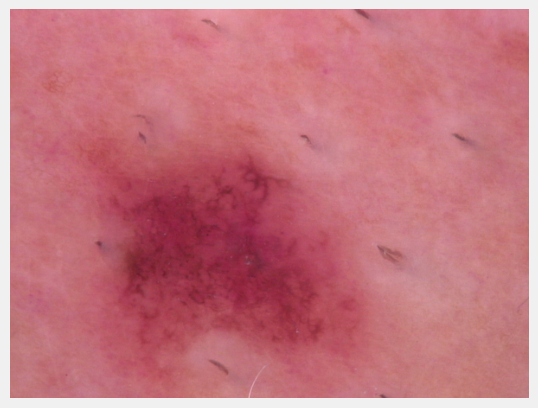

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the saved result image
path = r"C:\Users\Harsha Vardhan\Downloads\skincancer\images\ISIC_0024309.jpg"

# Read and display the image
image = mpimg.imread(path)
plt.imshow(image)
plt.axis('off')
plt.show()


# Save the Model

In [30]:
model.save('skindoubleunet.h5')

C:\Users\Harsha Vardhan\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predication

1/1 [==============================] - 2s 2s/step


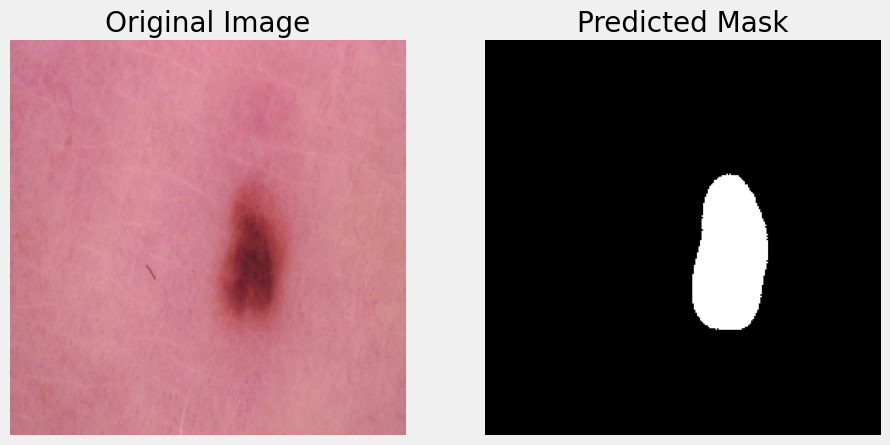

In [37]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import CustomObjectScope

# Define custom metrics if they were used in the model
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Function to load the model and predict the result
def predict_skin_lesion(image_path, model_path=r"C:\Users\Harsha Vardhan\skindoubleunet.h5"):
    # Load the saved model
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
        model = tf.keras.models.load_model(model_path)
    
    # Preprocess the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    original_image = cv2.resize(image, (256, 256))
    image = original_image / 255.0
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    
    # Predict the mask
    prediction = model.predict(image)[0] > 0.5
    prediction = np.squeeze(prediction, axis=-1)
    prediction = prediction.astype(np.float32)
    
    # Display the original image and the predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(original_image[..., ::-1])  # Convert BGR to RGB
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(prediction, cmap='gray')
    plt.axis('off')
    
    plt.show()

    return prediction

# Example usage:
image_path = r"C:\Users\Harsha Vardhan\Downloads\skincancer\images\ISIC_0024404.jpg"
predicted_mask = predict_skin_lesion(image_path)
